In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import time
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from torchsummary import summary
from collections import deque
import os

from di_dataset3 import DepthImageDataset, collate_batch

from torch.utils.tensorboard import SummaryWriter

2022-03-17 19:25:42.350530: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

# Hyperparams

In [3]:
LINUX = False
LINUX_REMOTE = True

latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False
one_tfrecord = True

if LINUX:
    base_path = "/home/patricknit"
elif LINUX_REMOTE:
    base_path = "/home/user/patricknit"
    one_tfrecord = True
    batch_size = batch_size * 3
else:
    base_path = "/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code"

tfrecord_folder = base_path + "/rl_data/tfrecord_wfiltered"
tfrecord_test_folder = tfrecord_folder + "/test"

save_model_file = base_path + "/vae_models/dronet2_128_64_final_MSE-sum_weighted_filtered"
load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"

writer = SummaryWriter('runs'+save_model_file[save_model_file.rfind("/"):])

# Load Dataset

In [4]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=one_tfrecord) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=one_tfrecord, test=True) # 20 tfrecords

len_train_dataset, len_test_dataset = len(train_dataset), len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

images, images_filtered, *_ = next(iter(train_loader)) # image, filtered image, height, width, depth
images.shape, images_filtered.shape

Loading tfrecords... 	['/home/user/patricknit/rl_data/tfrecord_wfiltered/data40.tfrecords']


2022-03-17 19:25:43.817867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-17 19:25:43.818013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-17 19:25:43.819131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-17 19:25:43.820124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:67:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-17 19:25:43.821114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:68:00.0 na

Iterating length... 	Done: 20
Loading tfrecords... 	['/home/user/patricknit/rl_data/tfrecord_wfiltered/test/data186.tfrecords']
Iterating length... 	Done: 26
20 26
gotcha


(torch.Size([96, 1, 270, 480]), torch.Size([96, 1, 270, 480]))

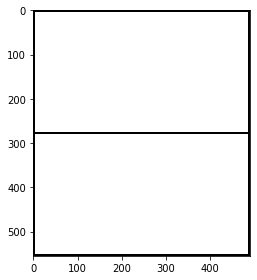

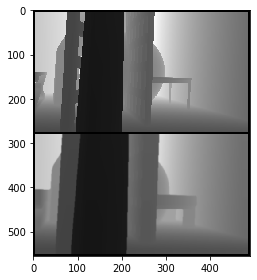

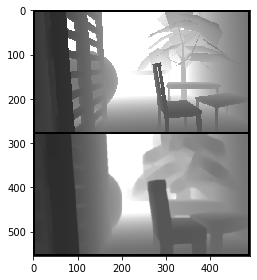

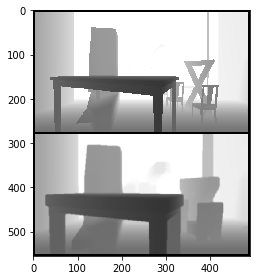

In [5]:
def imshow(image):
    io.imshow(image.cpu().squeeze().numpy())
    io.show()

def make_grid_for_tensorboard(images_list, n_grids=2):
    joined_images = []
    [joined_images.extend(images[:n_grids]) for images in images_list]
    return torchvision.utils.make_grid(joined_images, nrow=1, padding=5)

def gridshow(images_list, n_grids=None):
    for n, items in enumerate(zip(*images_list)):
        grid = torchvision.utils.make_grid([*items], nrow=1, padding=5).permute(1, 2, 0)
        imshow(grid)
        if (n+1) == n_grids:
            return

gridshow([images, images_filtered], n_grids=4)
#imshow(make_grid_for_tensorboard([images, images_filtered]).permute(1,2,0))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [39]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs):
        super(Dronet, self).__init__()
        
        print('[Dronet] Starting dronet')

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 128) # Todo: check size
        self.dense1 = nn.Linear(128, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        x1 = self.conv0(img)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)

        # First residual block
        x2 = self.bn0(x1)
        x2 = torch.relu(x2)
        x2 = self.conv1(x2)

        x2 = self.bn1(x2)
        x2 = torch.relu(x2)
        x2 = self.conv2(x2)
        
        x1 = self.conv3(x1)
        x3 = x1+x2

        # Second residual block
        x4 = self.bn2(x3)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)

        x4 = self.bn3(x4)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        
        x3 = self.conv6(x3)
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        x7 = x5+x6 # 17, 30, 128
        
        x = x7.view(x7.size(0), 9*15*128)

        x = torch.relu(x)
        x = self.dense0(x)
        x = torch.relu(x)        
        x_enc = self.dense1(x)
        return x_enc

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2).to(device)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(16)
        
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        x = self.dense(z)
        x = x.view(x.size(0), 128, 9, 15)
        
        x = self.deconv1(x)
#         x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.deconv2(x)
#         x = self.bn2(x)
        x = torch.relu(x)
        
        x = self.deconv3(x)
#         x = self.bn3(x)
        x = torch.relu(x)

        x = self.deconv4(x)
#         x = self.bn4(x)
        x = torch.relu(x)

        x = self.deconv5(x)
#         x = self.bn5(x)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
        x = torch.relu(x)
        
        x = self.deconv6(x)
#         x = self.bn6(x)
        x = torch.relu(x)

        x = self.deconv7(x)
        x = torch.sigmoid(x)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1).to(device)
summary(img_decoder, (1,latent_dim), device=device.type)

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        img_recon = self.p_img(z)
        return img_recon


[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Define Model

In [41]:
vae_model = VAE(n_z=latent_dim)
vae_model = vae_model.to(device)
summary(vae_model, (1, 270, 480))

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    vae_model = nn.DataParallel(vae_model)
    vae_model = vae_model.to(device0)


if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    print(f"Loaded model: {load_model_file}")


optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 3

# Training

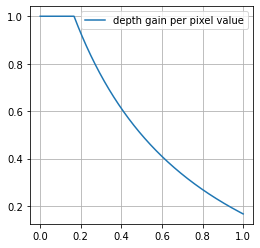

In [8]:
def depth_gain(x):
    return torch.minimum(1/(x + 0.5) - 0.5, 1*torch.ones_like(x))

x = torch.arange(0, 1.001, 0.001)
y = depth_gain(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.grid()
plt.legend(["depth gain per pixel value"])
plt.show()

In [9]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='mean')(x_hat, x) * (270 * 480)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="mean") * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum() # Old version, reduce by mean later
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

def filtered_weighted_MSE(filtered_x, x_hat, mu, logvar): 
    reproduction_loss = (depth_gain(filtered_x) * torch.square(x_hat - filtered_x)).mean() * (270 * 480) # change later to mean
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

In [10]:
time_iteration = deque(maxlen=100)
total_train_iterations = 0
total_test_iterations = 0

if load_model:
    start = load_model_file.rfind("_") + 1
    end = load_model_file.rfind(".")
    epoch_start = int("".join([char for char in load_model_file[start:end]]))
    num_epochs = [epoch_start, num_epochs]
else:
    num_epochs = [num_epochs] if isinstance(num_epochs, int) else num_epochs

for epoch in range(*num_epochs):
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    train_iterations = len(train_loader)

    test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)
    test_iterations = len(test_loader)
    
    print("Training...")
    vae_model.train()
    running_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(train_loader):
        since_iter = time.time() 
        optimiser.zero_grad()
        
        image = image.to(device0)
        image_filtered = image_filtered.to(device0)

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = weighted_MSE(image_filtered, x_hat, mu, logvar)
        running_loss += loss.item()

        # Update weights
        loss.backward()
        optimiser.step()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('training/loss', running_loss/((i+1)*batch_size), global_step=total_train_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{train_iterations}, Avg. train loss:", \
                  f"{running_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(train_iterations - (i+1)):.2f}")
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('training/images', grid, global_step=total_train_iterations)
            
        total_train_iterations += 1
    
    print("Testing...")
    vae_model.eval()
    test_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(test_loader):
        since_iter = time.time() 
        optimiser.zero_grad()
        
        image = image.to(device0)
        image_filtered = image_filtered.to(device0)

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = weighted_MSE(image_filtered, x_hat, mu, logvar)
        test_loss += loss.item()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('test/loss', test_loss/((i+1)*batch_size), global_step=total_test_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{test_iterations}, Avg. test loss:", \
                  f"{test_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(test_iterations - (i+1)):.2f}")
            
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('test/images', grid, global_step=total_test_iterations)
            
        total_test_iterations += 1
    
    print(f"Epoch: {epoch+1}, Training loss: {running_loss/(train_iterations*batch_size):.3f}, Test loss: {test_loss/(test_iterations*batch_size):.3f}")
    writer.add_scalar('loss_per_epoch/train', running_loss/(train_iterations*batch_size), global_step=epoch)
    writer.add_scalar('loss_per_epoch/test', test_loss/(test_iterations*batch_size), global_step=epoch)

    
    # Save every 10 epochs
    if save_model and (epoch+1) % 10 == 0:
        save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
        torch.save(vae_model.state_dict(), save_model_file_dir)
            

Loading tfrecords... 	['/home/user/patricknit/rl_data/tfrecord_wfiltered/data105.tfrecords']
Iterating length... 	Done: 22
Loading tfrecords... 	['/home/user/patricknit/rl_data/tfrecord_wfiltered/test/data183.tfrecords']
Iterating length... 	Done: 24
Training...
gotcha
Epoch: 1/250, Step: 5/22, Avg. train loss: 6318.457, time: 2.67, Avg. per iter 0.37, Est. time left 6.23
Epoch: 1/250, Step: 10/22, Avg. train loss: 5500.179, time: 3.97, Avg. per iter 0.25, Est. time left 2.97
Epoch: 1/250, Step: 15/22, Avg. train loss: 5027.851, time: 5.25, Avg. per iter 0.21, Est. time left 1.45
Epoch: 1/250, Step: 20/22, Avg. train loss: 4656.651, time: 6.53, Avg. per iter 0.19, Est. time left 0.38
Testing...
gotcha
Epoch: 1/250, Step: 5/24, Avg. test loss: 4210.484, time: 1.13, Avg. per iter 0.16, Est. time left 3.13
Epoch: 1/250, Step: 10/24, Avg. test loss: 4255.099, time: 1.91, Avg. per iter 0.15, Est. time left 2.16
Epoch: 1/250, Step: 15/24, Avg. test loss: 4273.112, time: 2.69, Avg. per iter 0

In [11]:
import tensorflow
print(tensorflow.test.gpu_device_name())

/device:GPU:0


2022-03-17 20:20:08.302079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-17 20:20:08.303800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:67:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-17 20:20:08.305549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-03-17 20:20:08.305703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library li

# Evaluation

In [45]:
load_model_file = save_model_file_dir # load last save
load_model_file = base_path + "/vae_models/dronet_final_64_sum_old_weight_250.pth"
load_model=True

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    print("Loaded model:", load_model_file)


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/patricknit/vae_models/dronet_final_64_sum_old_weight_250.pth'

gotcha
tensor(0.4399, device='cuda:0') tensor(0.3835, device='cuda:0') tensor(0.3656, device='cuda:0')
tensor(0.1241, device='cuda:0') tensor(0.1071, device='cuda:0') tensor(0.0964, device='cuda:0')


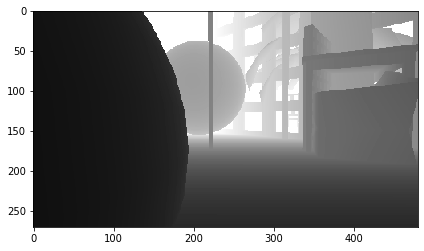

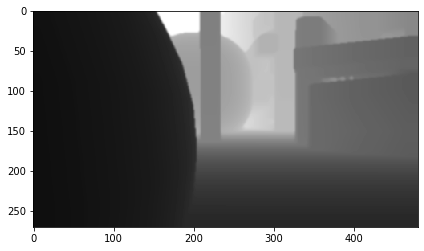

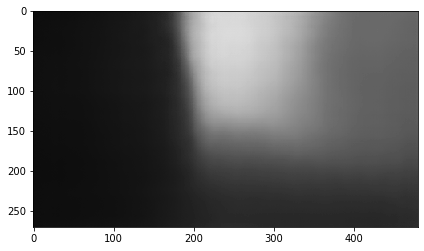

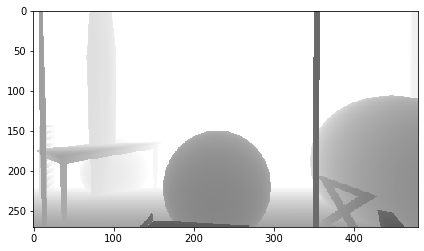

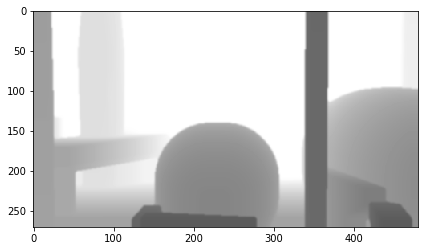

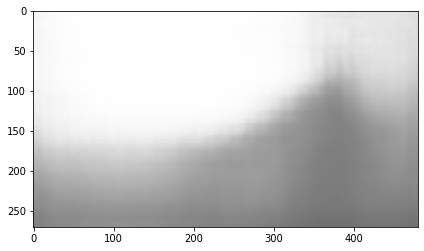

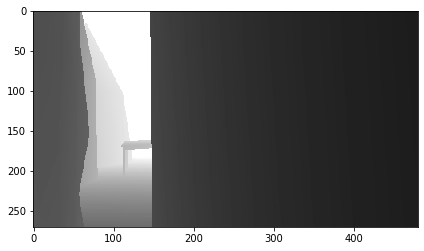

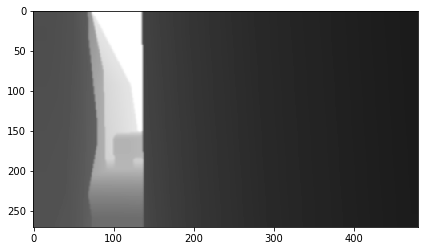

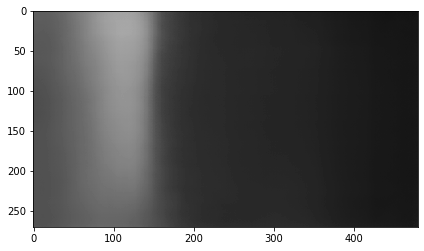

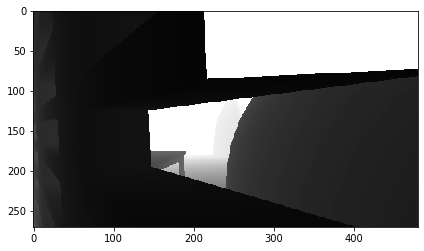

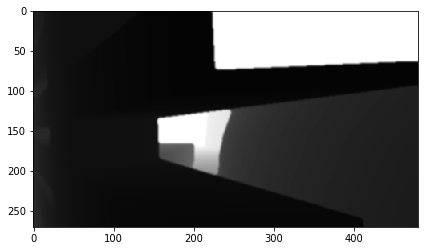

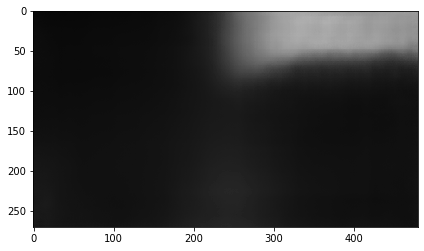

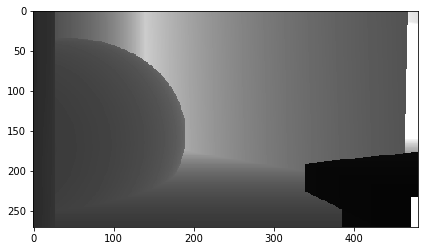

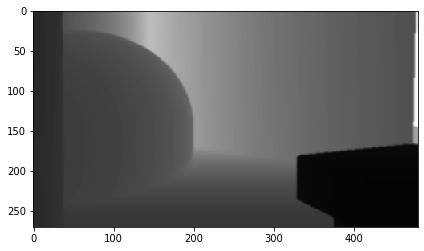

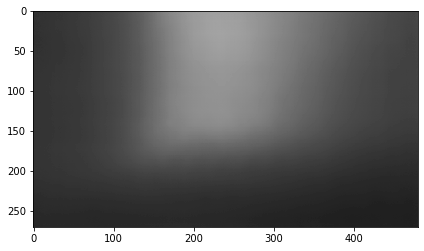

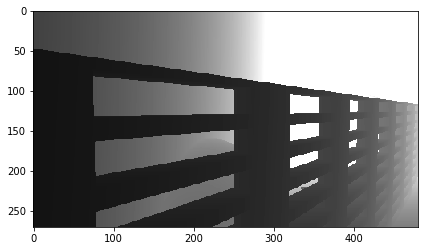

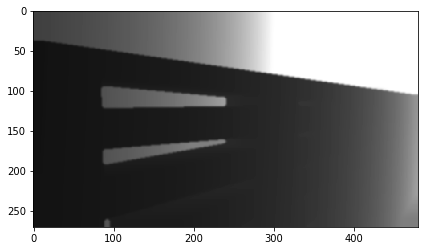

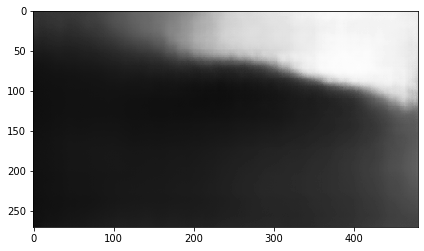

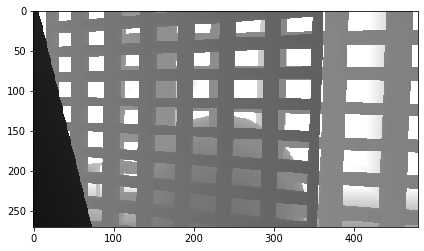

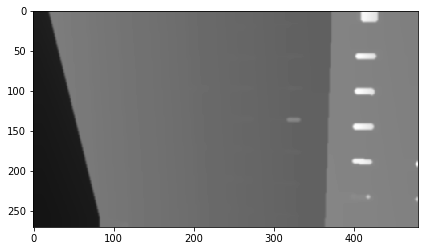

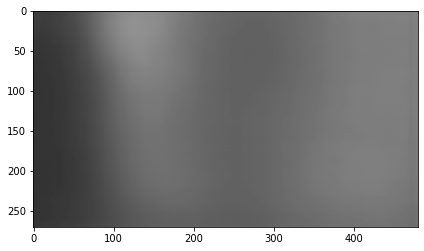

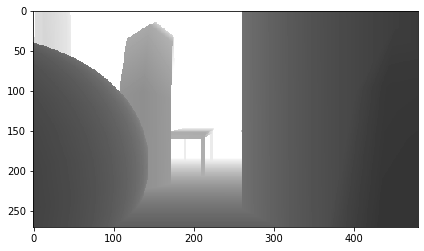

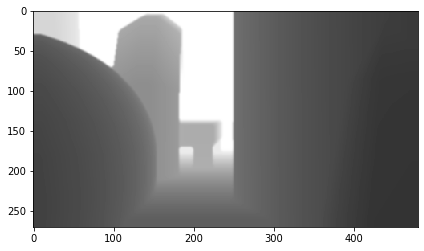

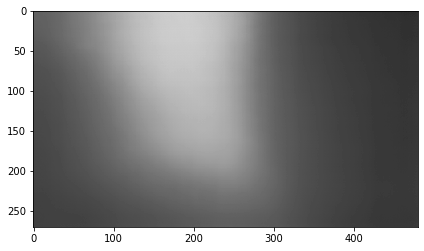

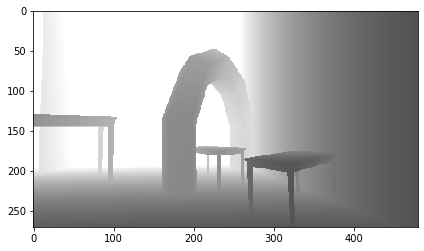

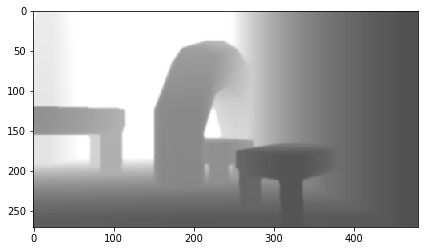

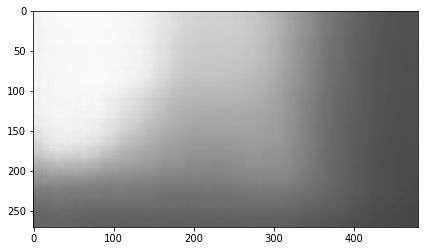

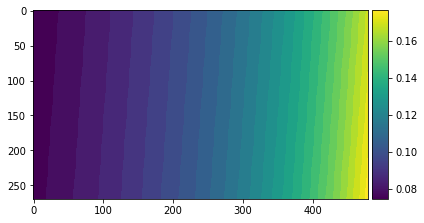

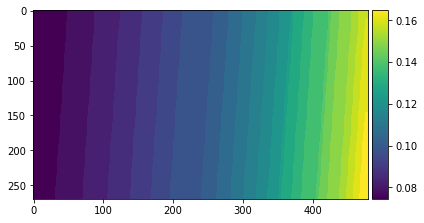

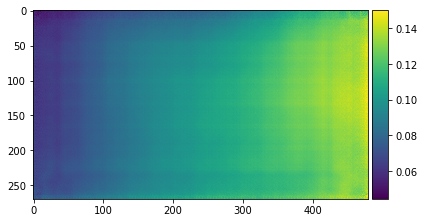

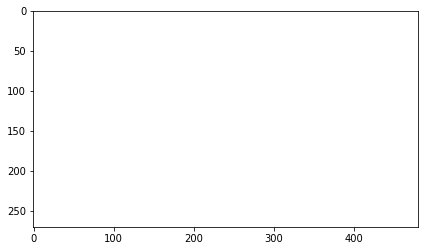

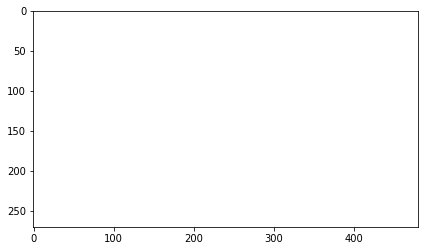

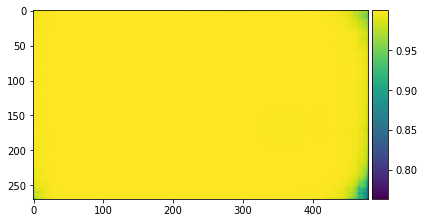

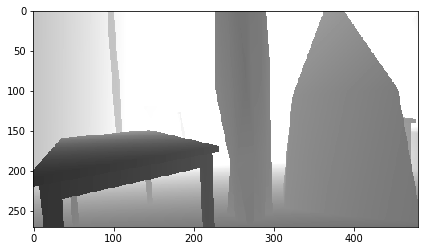

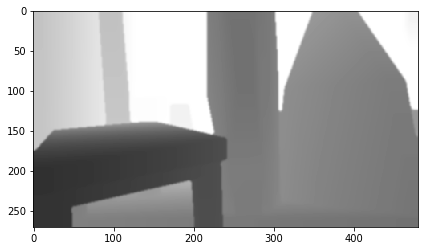

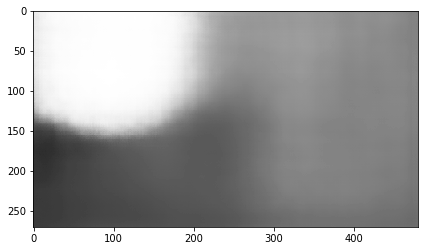

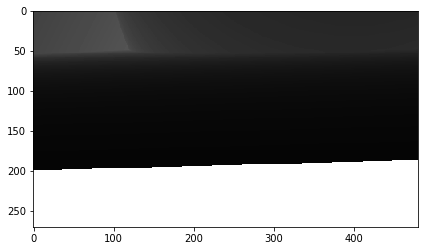

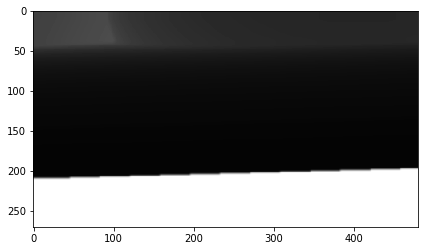

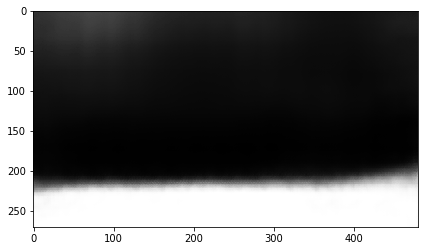

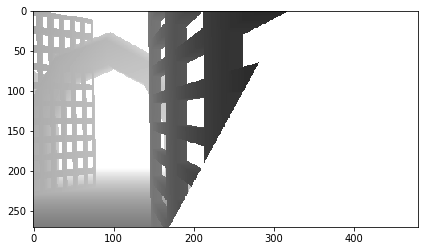

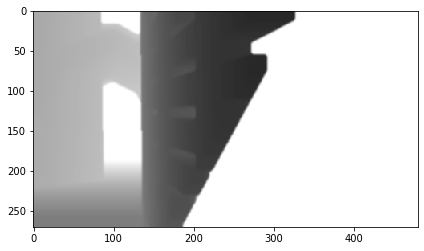

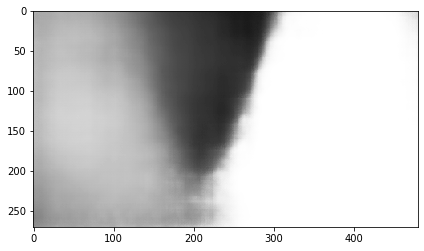

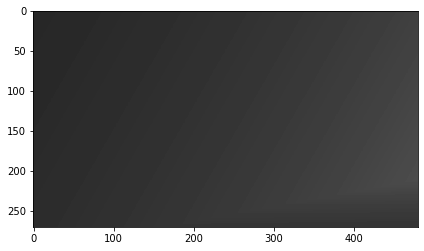

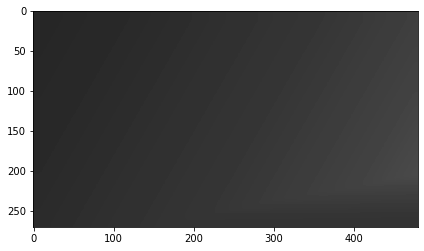

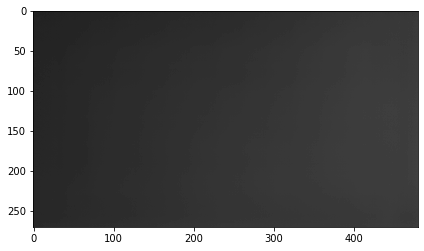

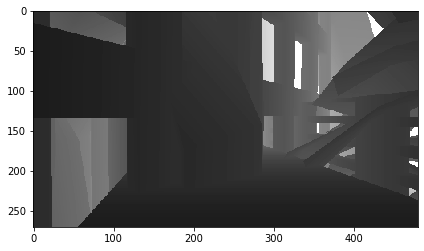

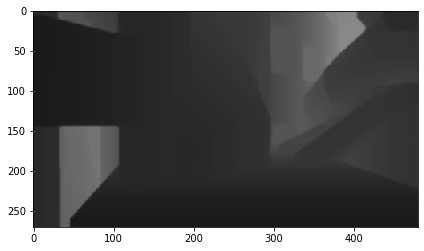

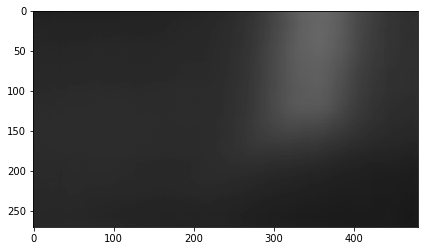

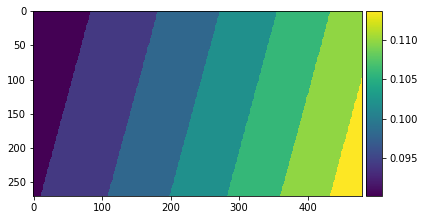

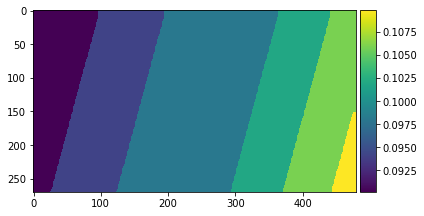

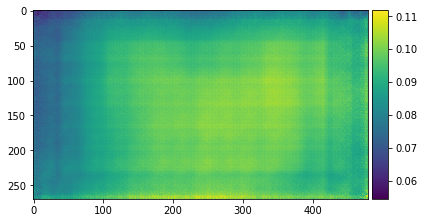

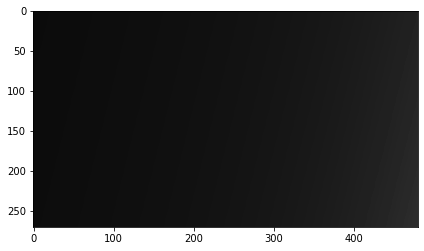

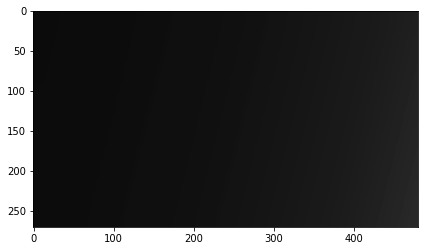

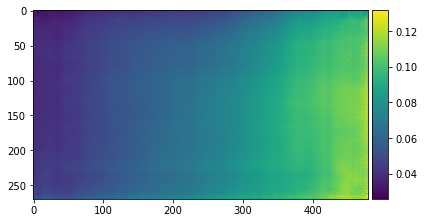

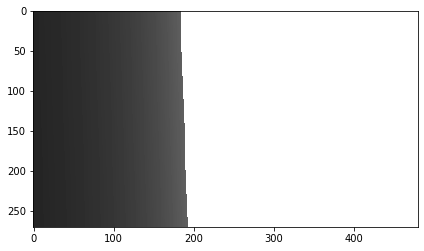

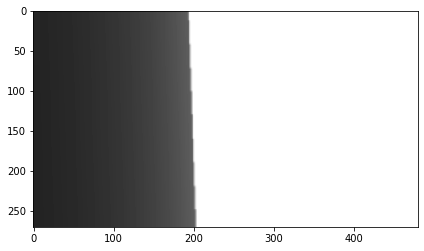

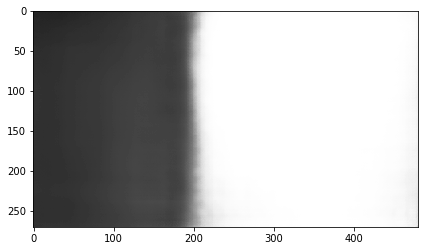

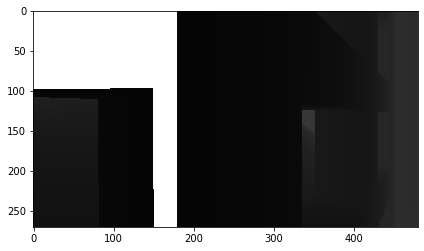

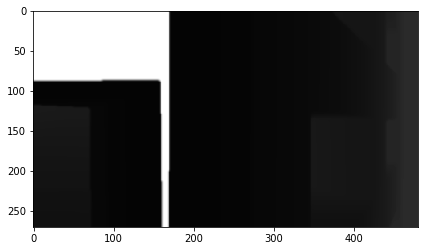

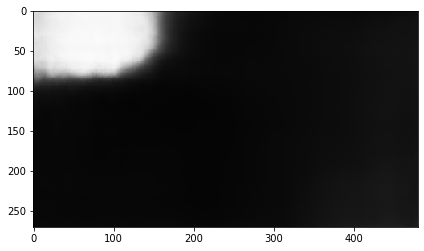

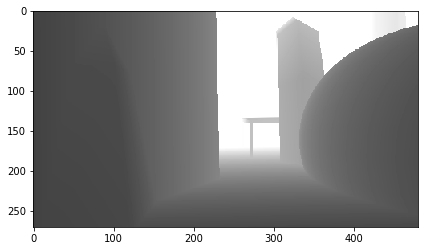

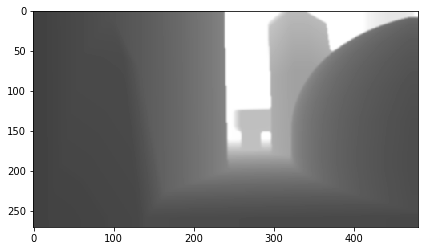

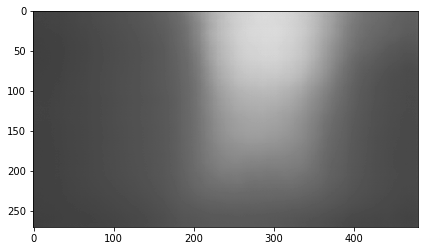

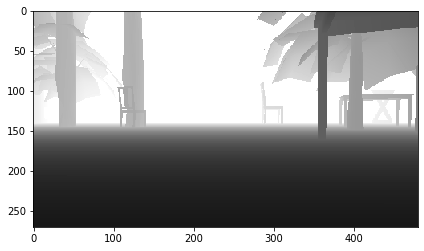

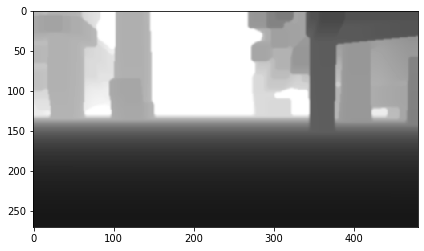

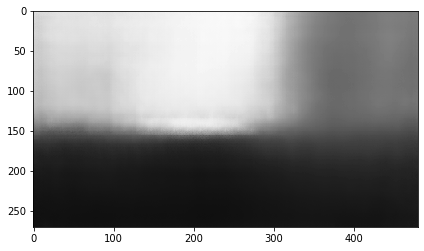

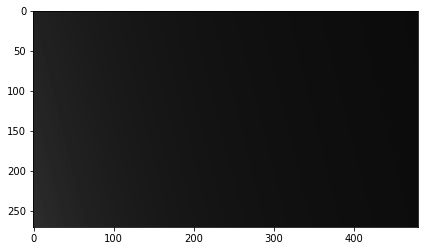

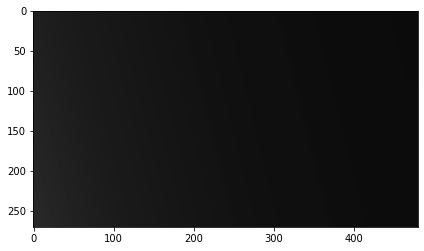

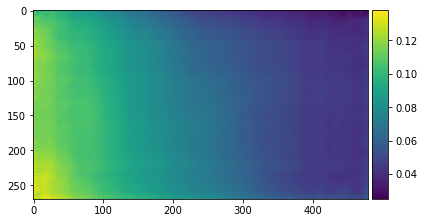

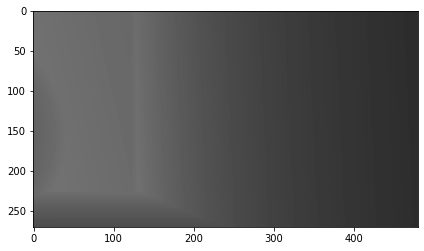

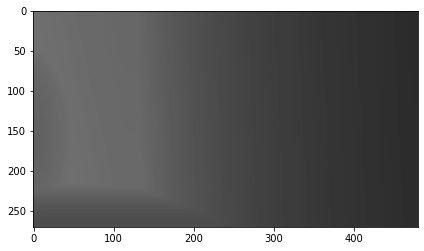

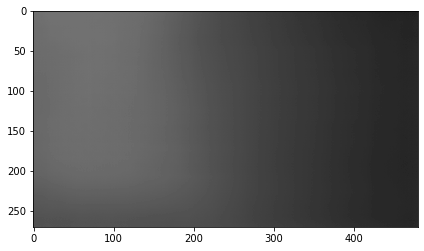

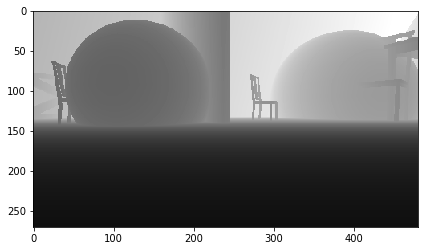

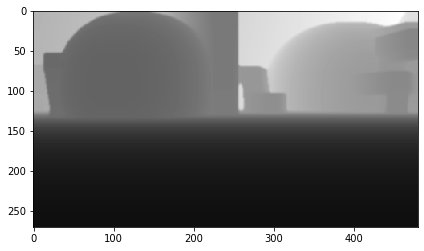

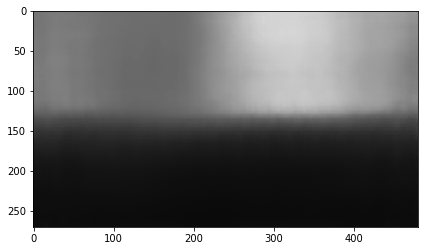

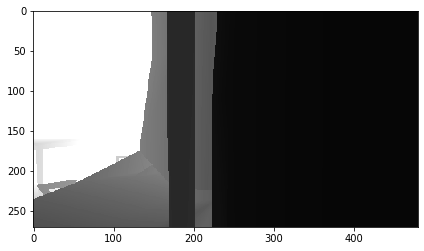

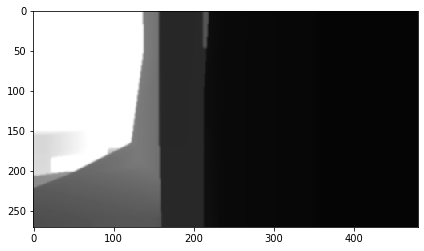

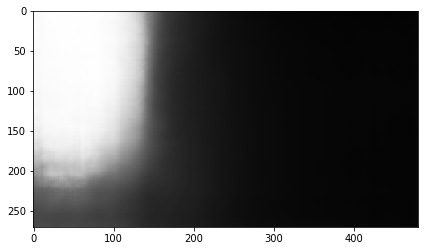

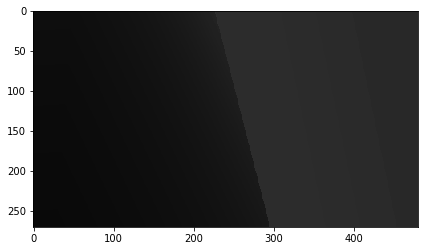

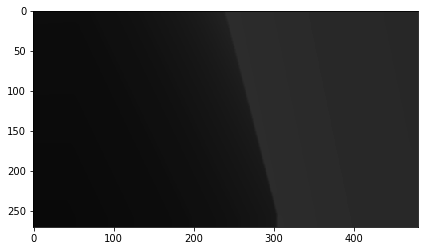

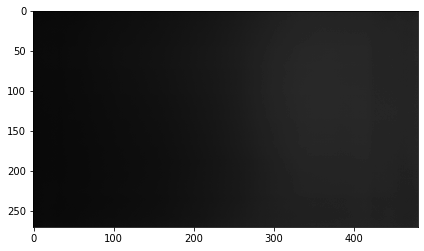

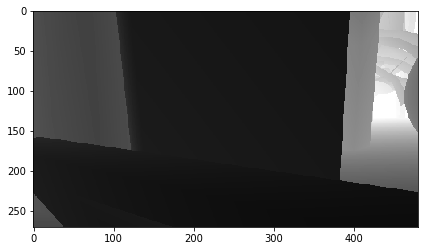

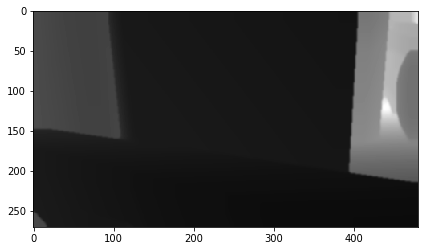

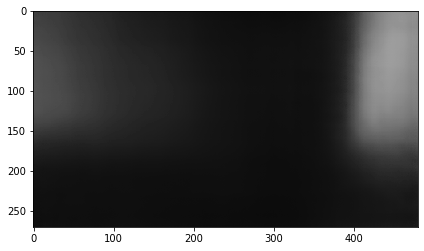

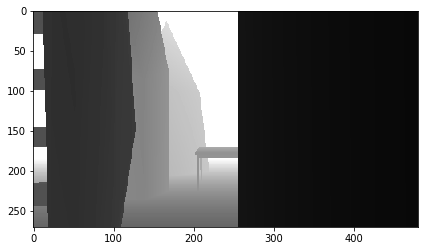

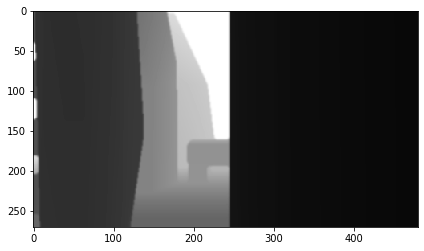

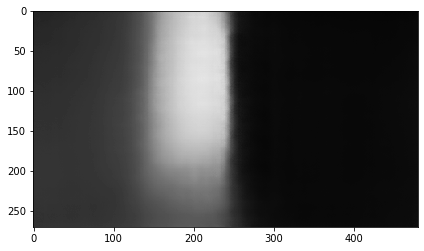

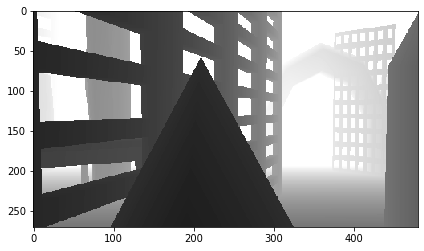

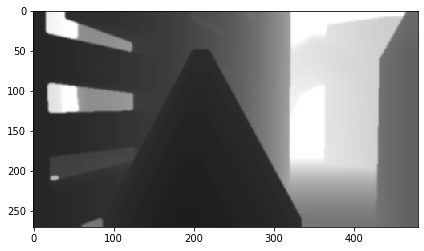

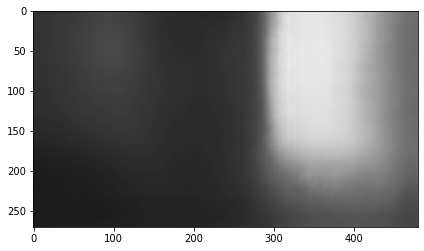

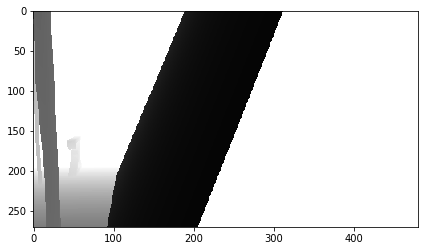

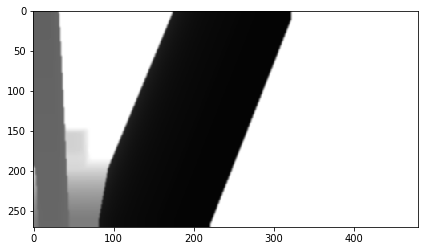

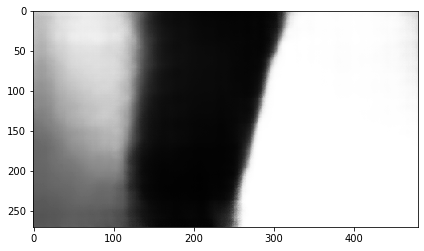

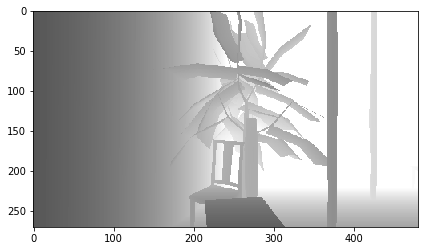

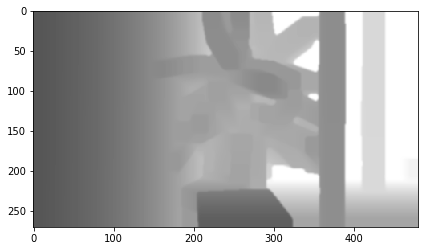

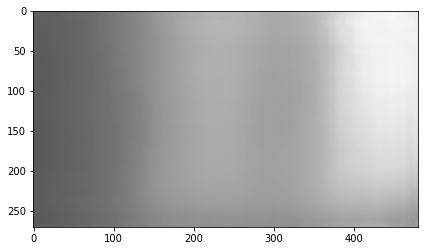

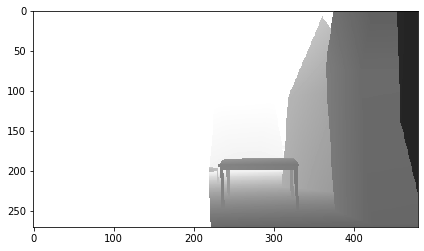

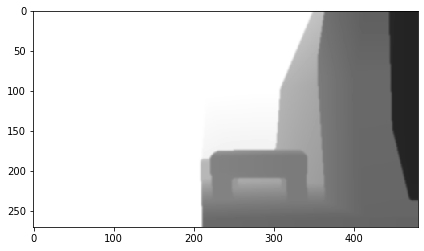

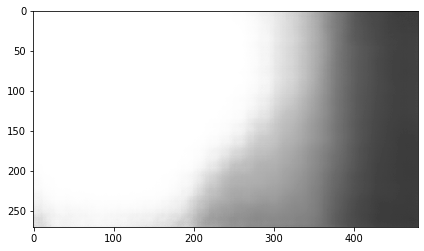

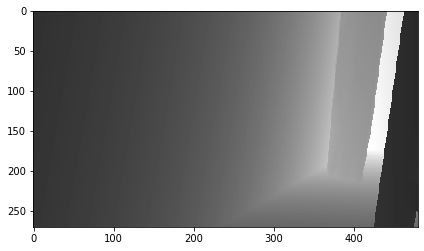

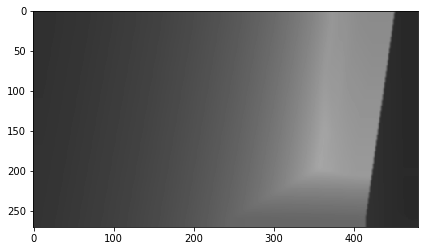

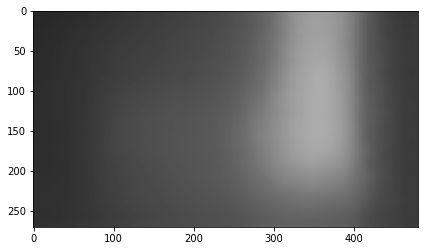

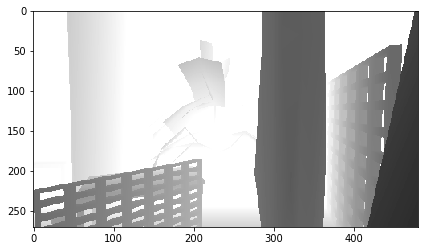

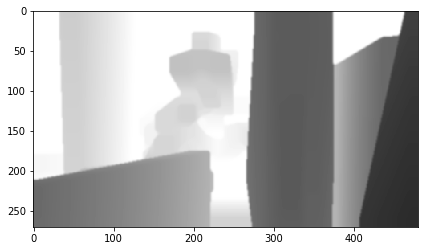

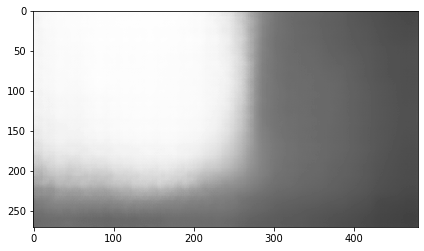

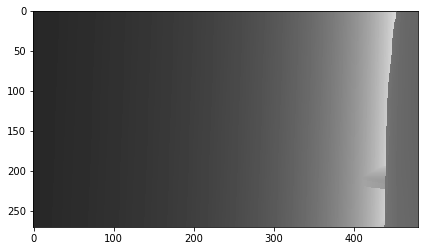

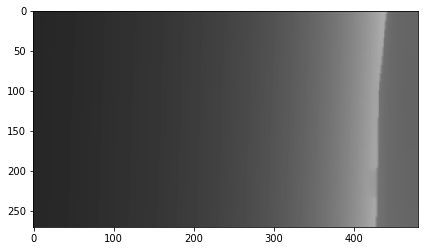

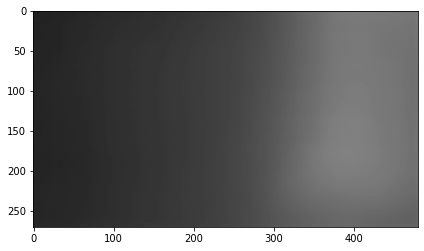

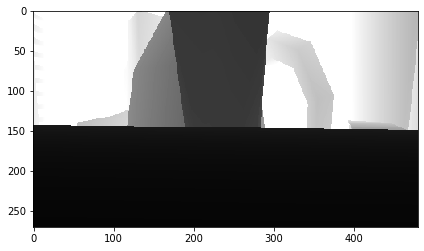

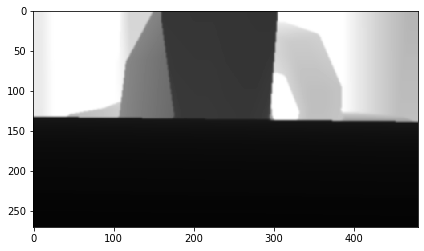

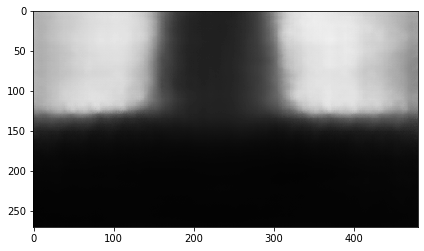

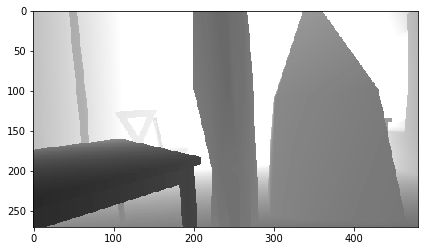

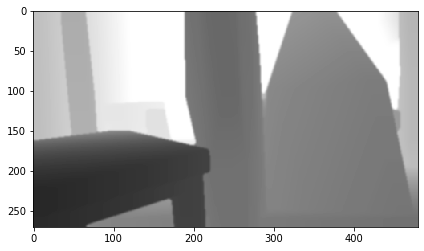

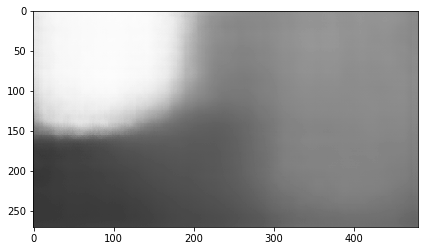

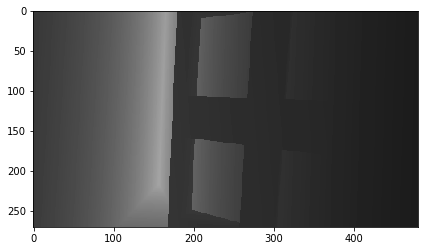

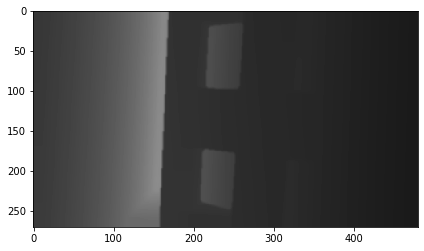

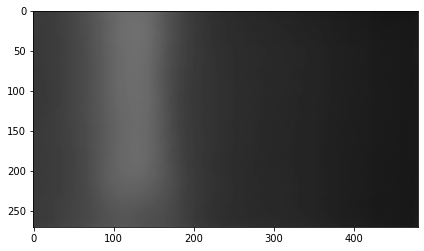

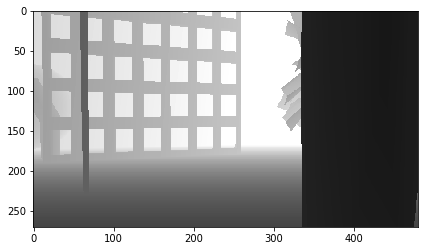

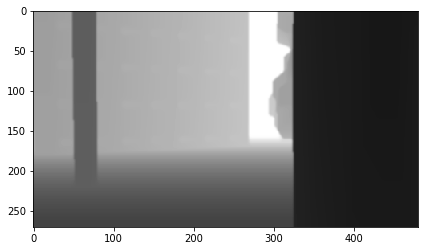

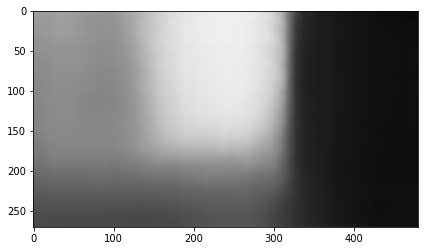

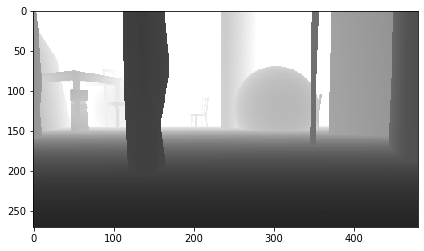

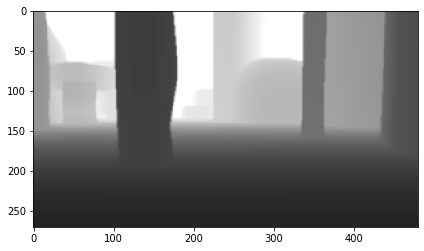

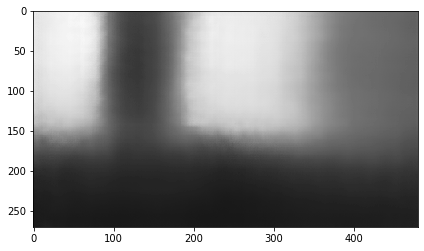

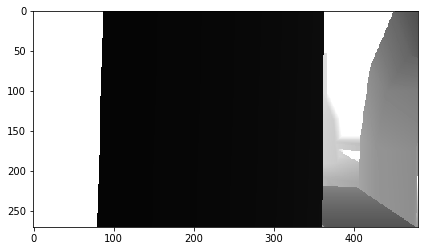

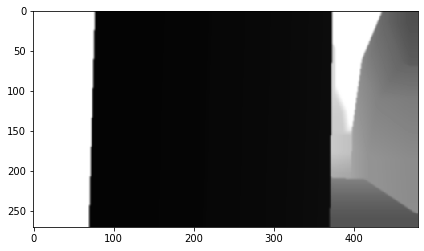

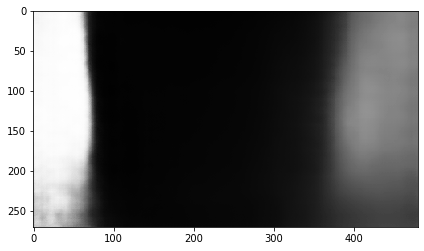

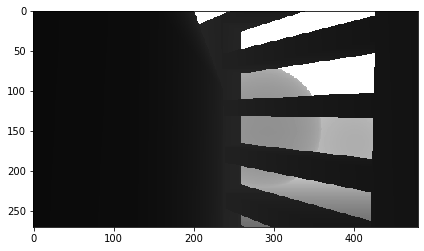

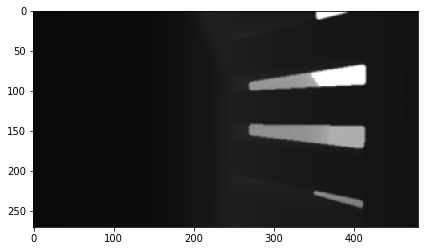

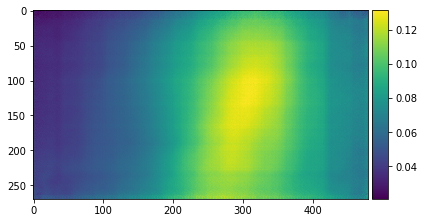

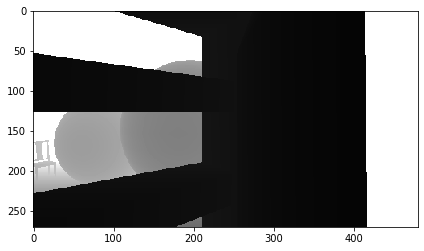

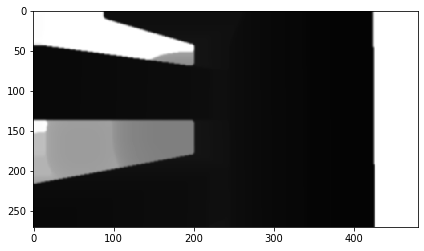

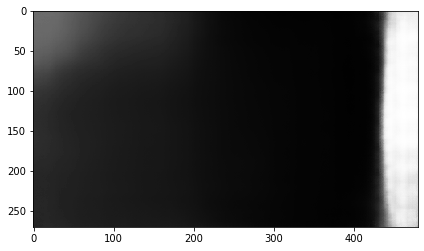

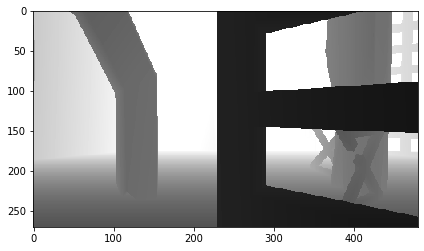

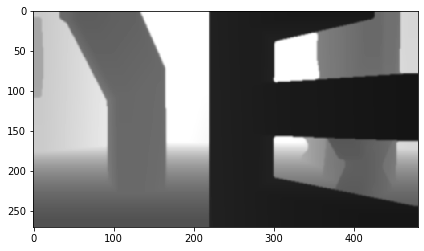

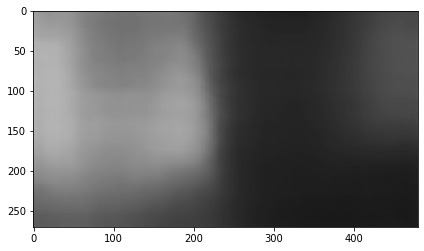

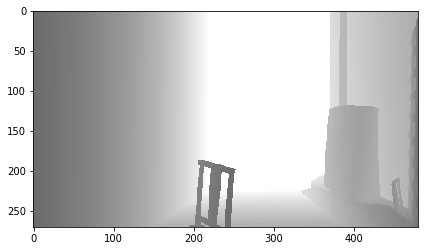

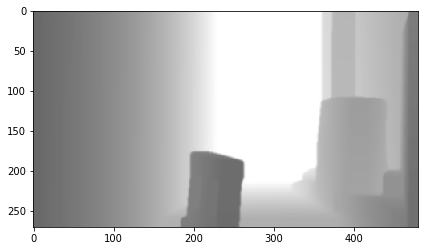

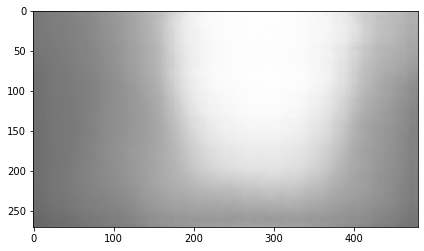

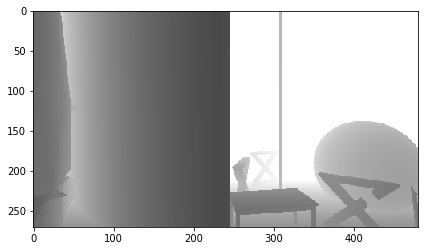

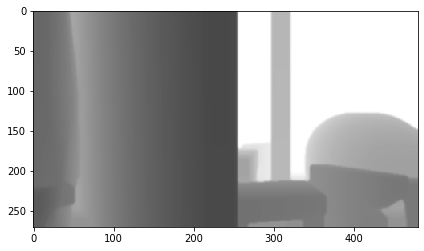

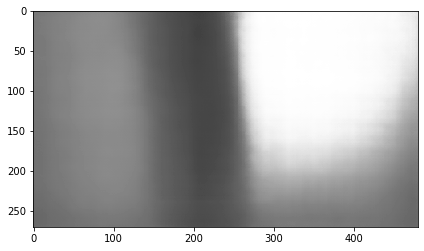

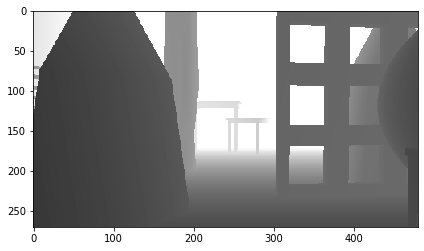

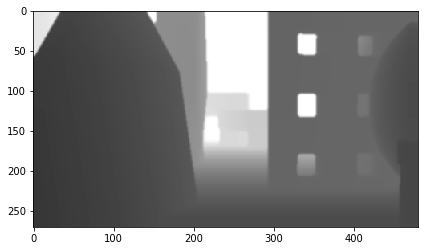

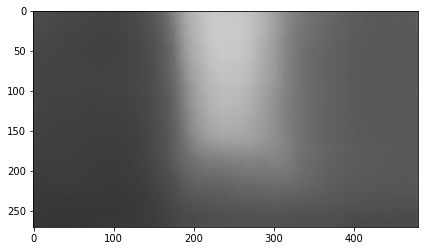

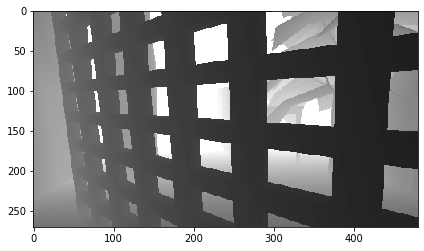

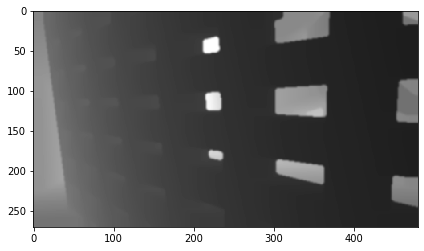

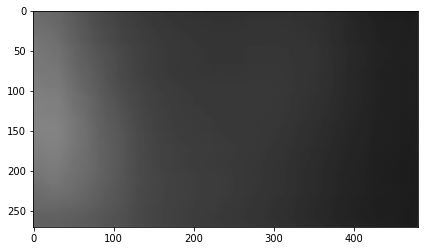

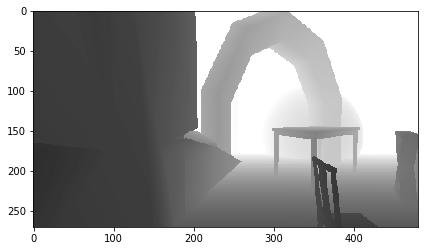

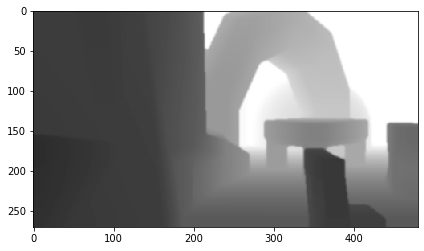

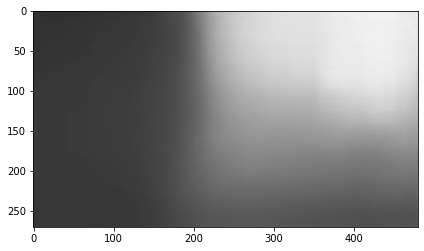

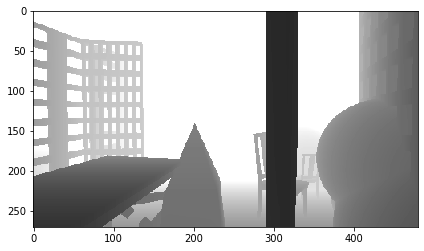

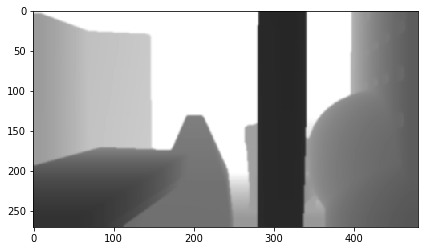

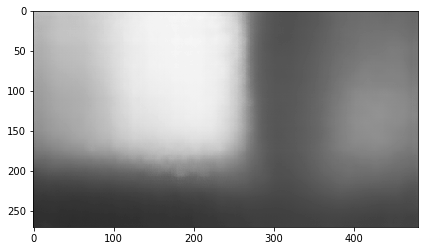

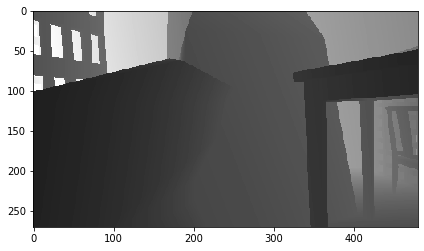

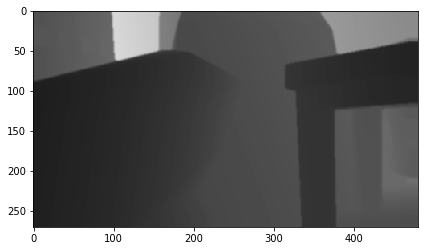

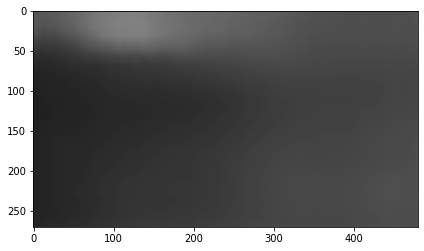

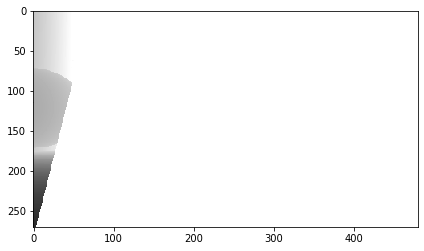

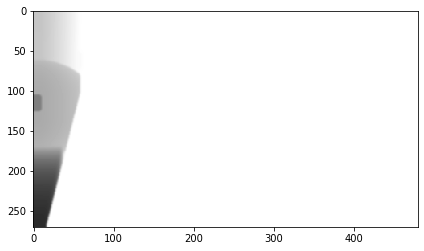

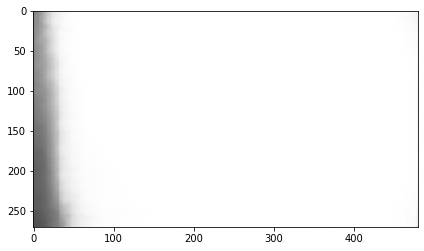

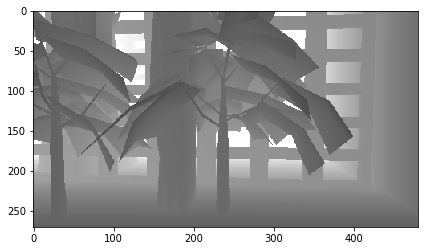

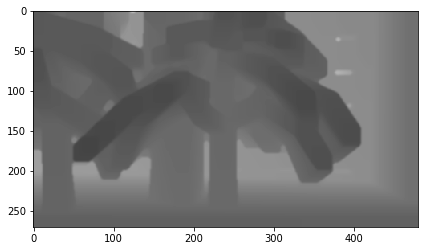

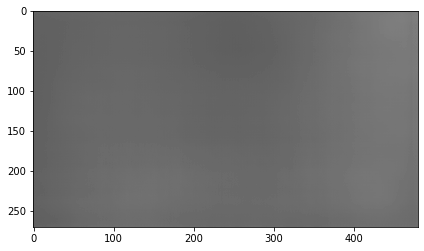

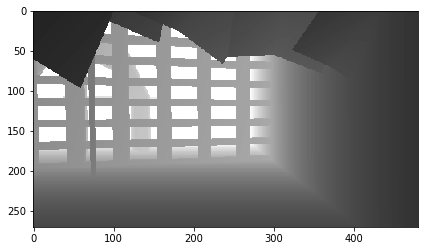

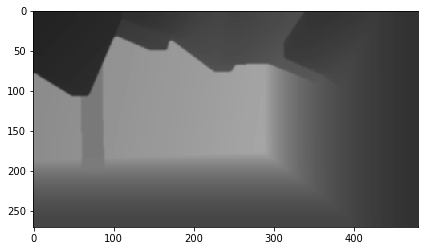

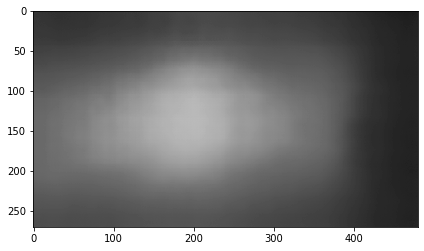

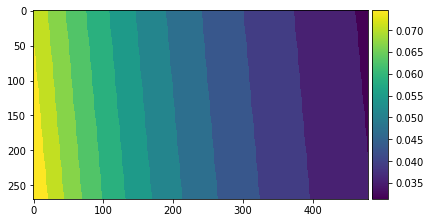

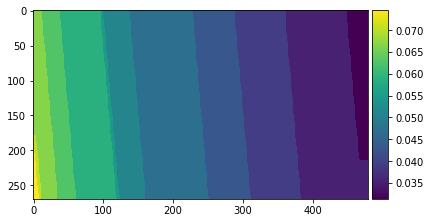

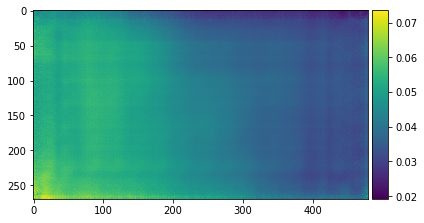

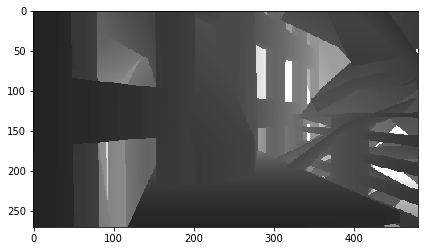

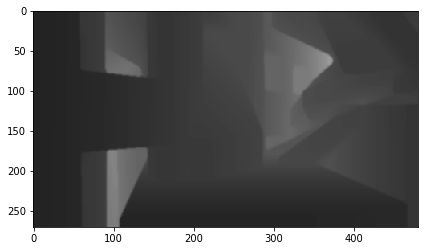

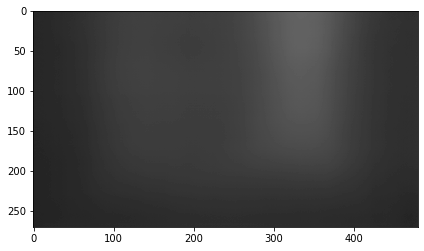

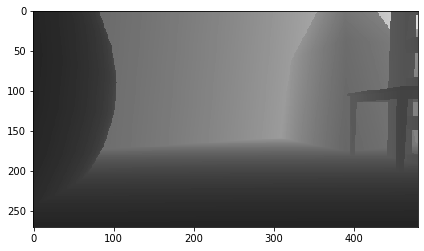

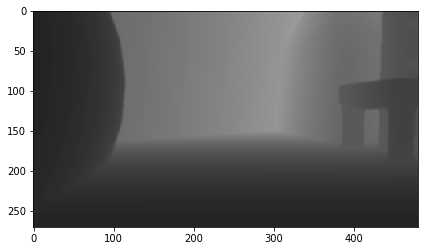

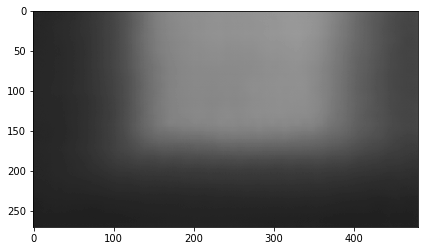

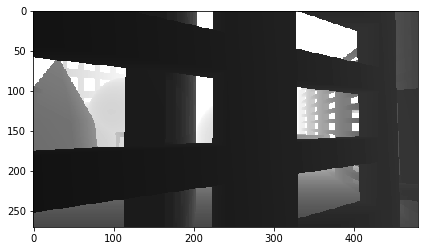

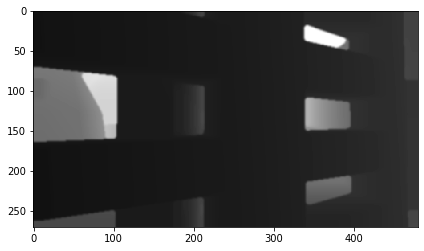

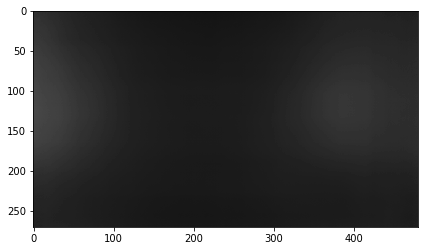

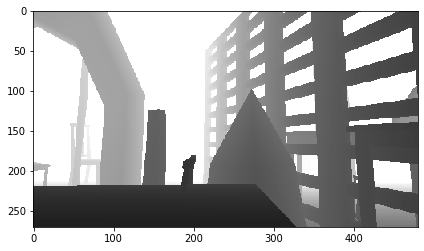

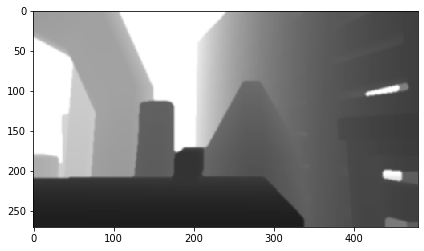

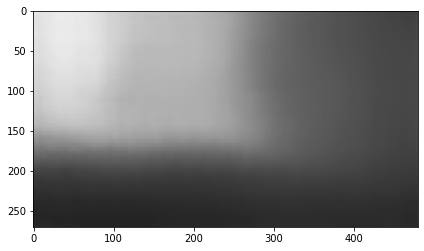

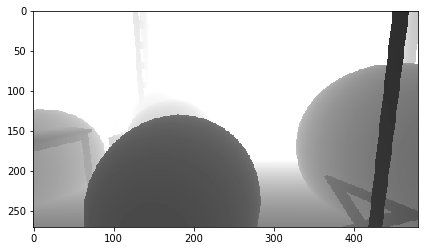

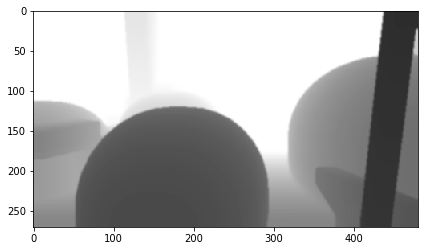

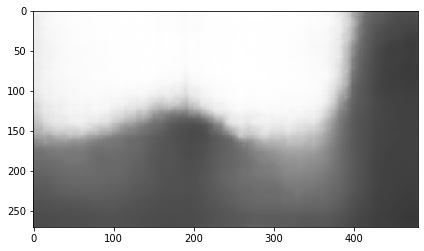

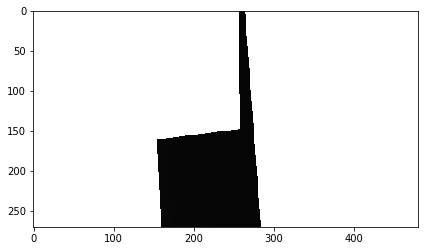

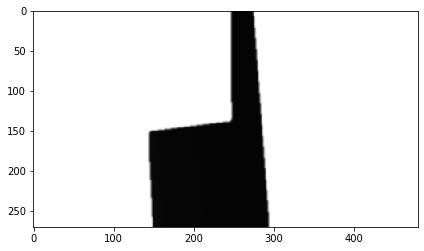

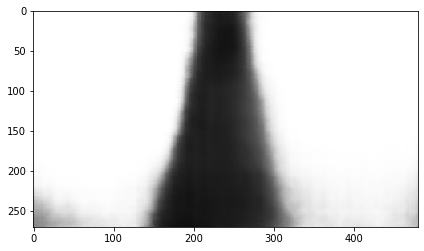

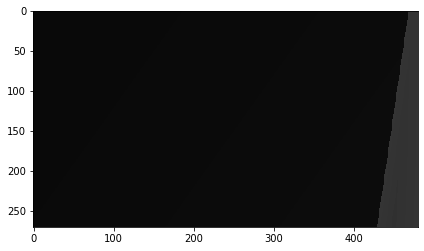

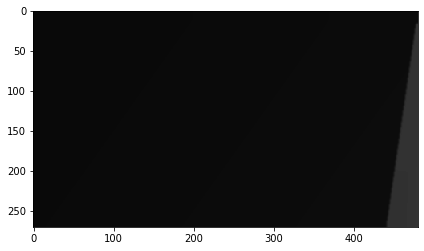

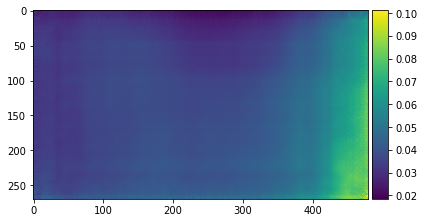

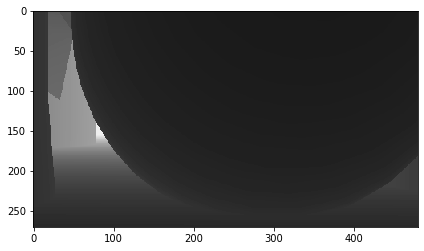

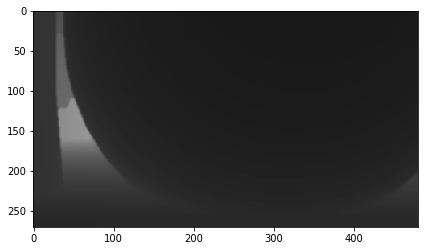

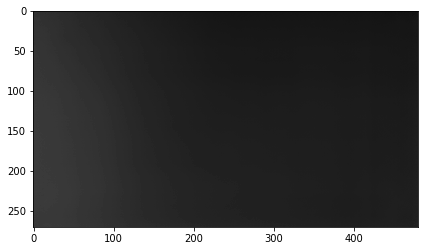

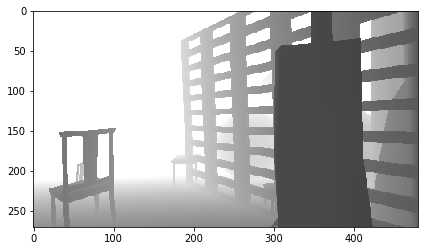

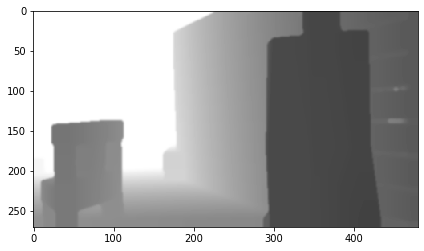

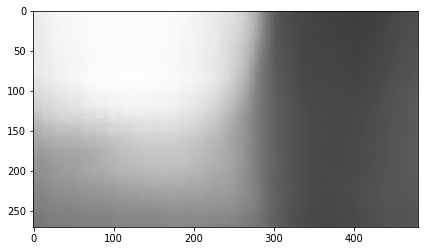

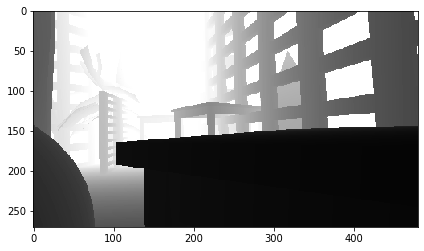

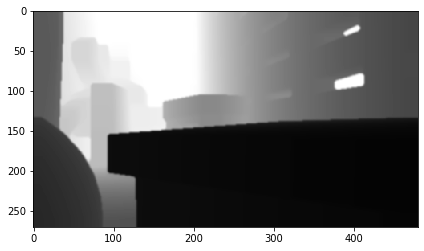

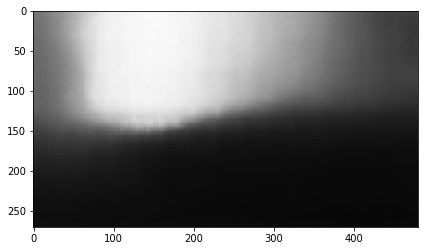

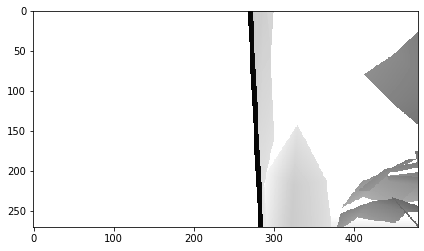

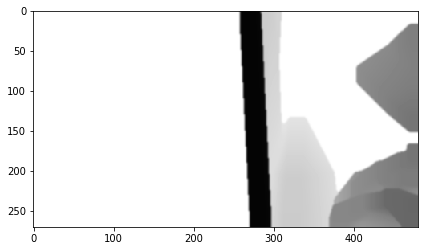

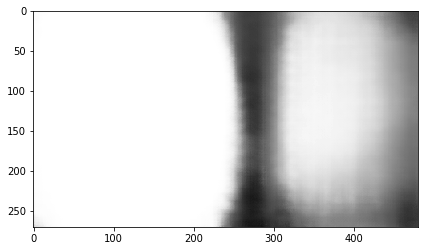

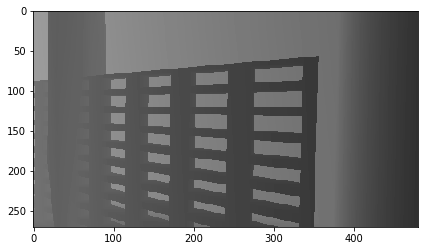

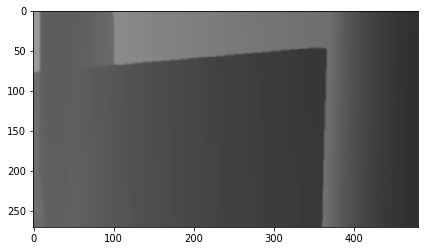

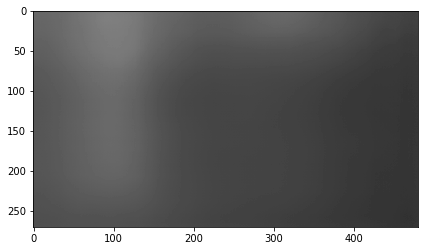

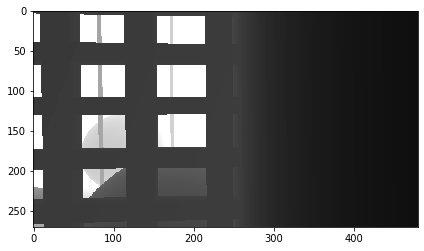

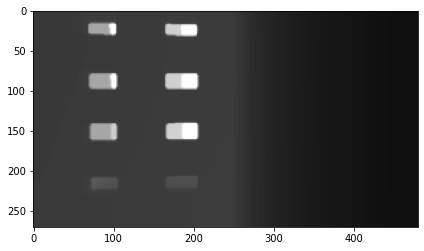

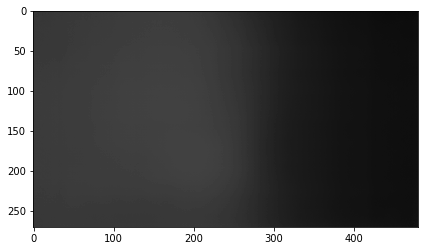

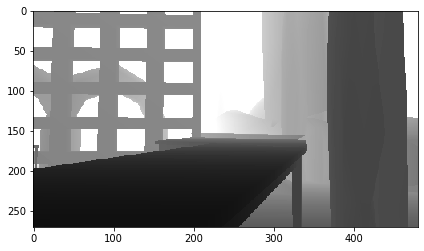

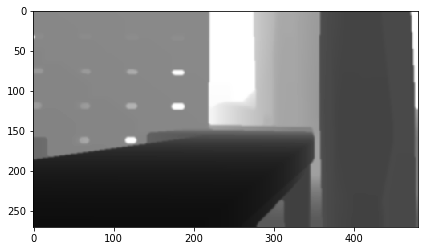

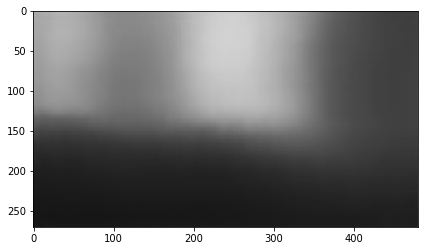

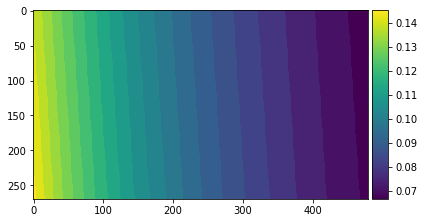

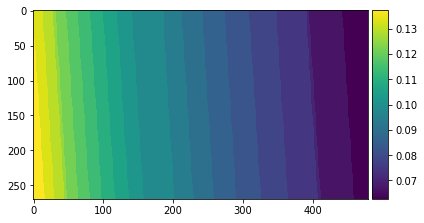

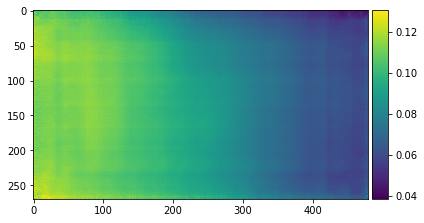

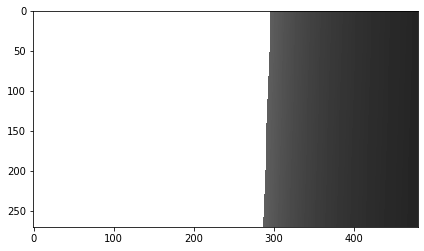

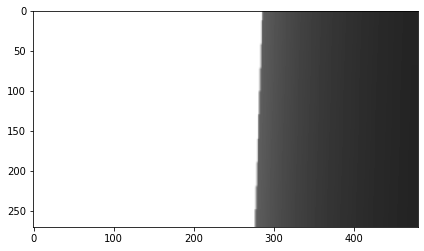

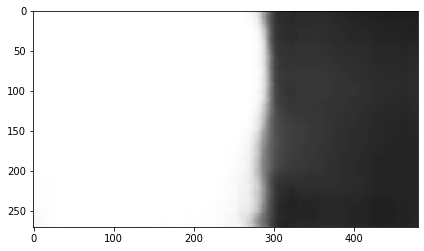

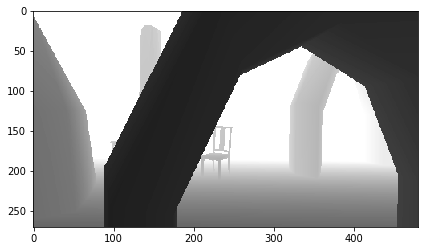

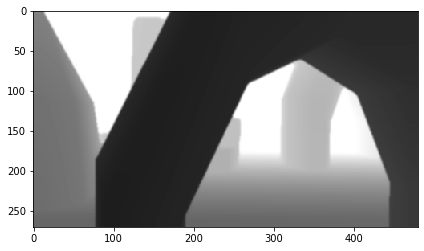

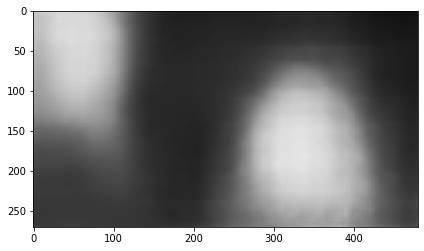

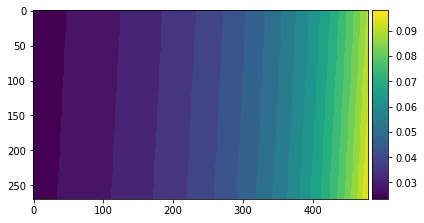

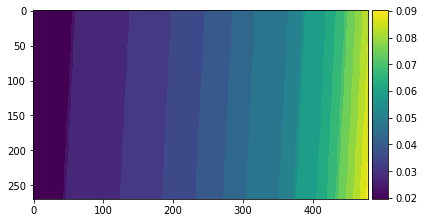

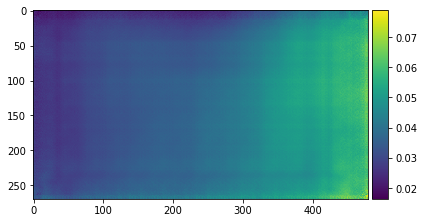

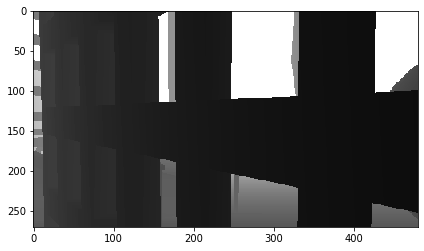

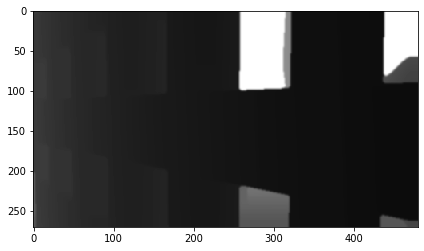

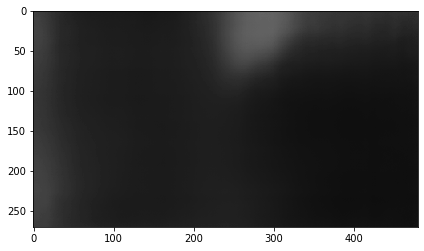

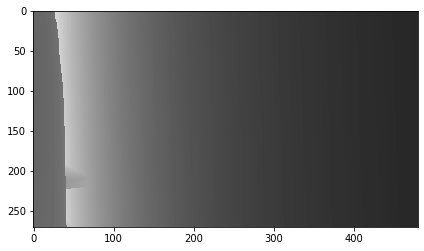

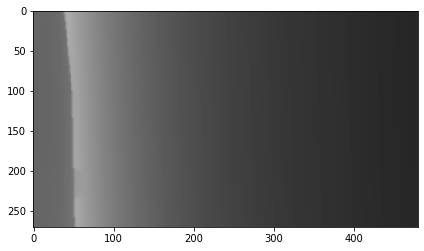

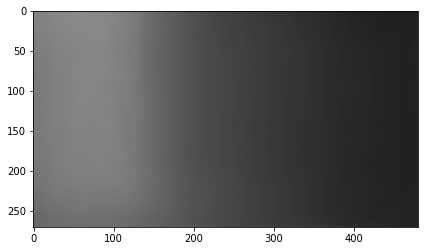

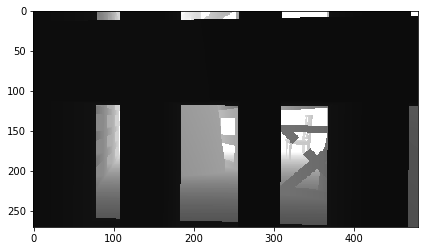

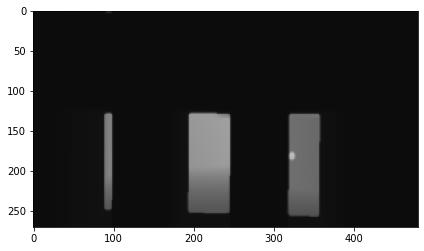

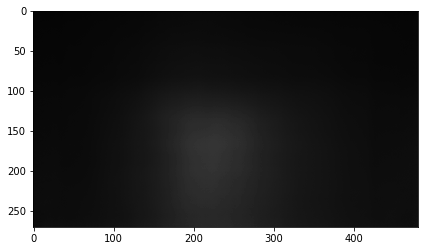

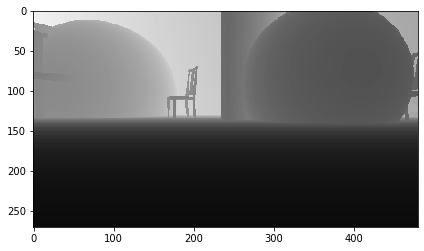

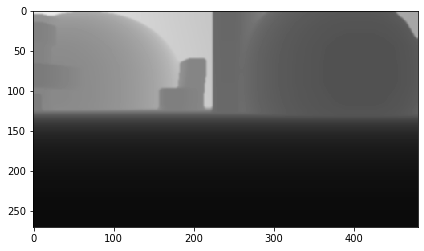

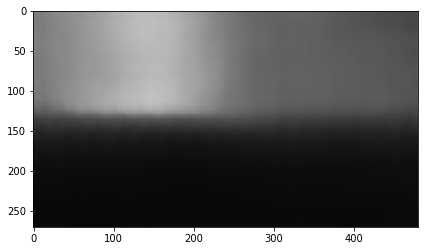

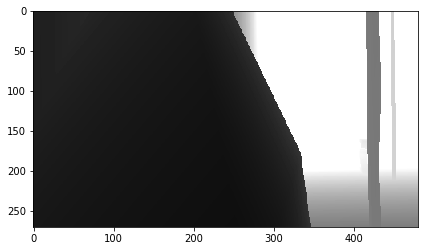

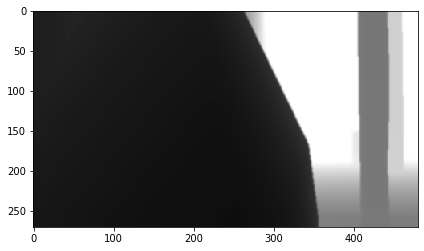

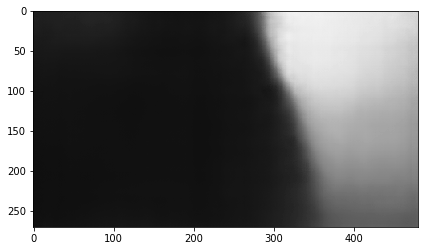

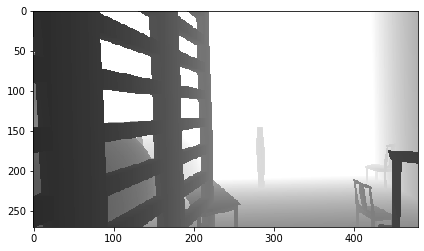

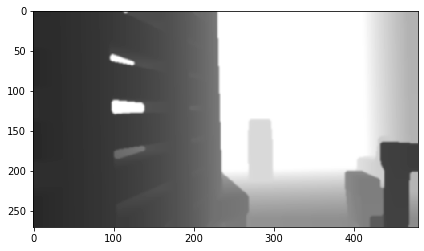

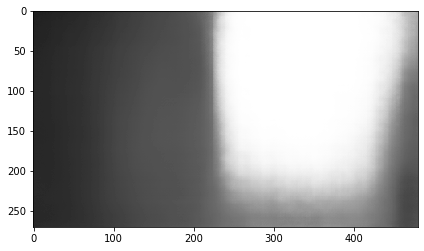

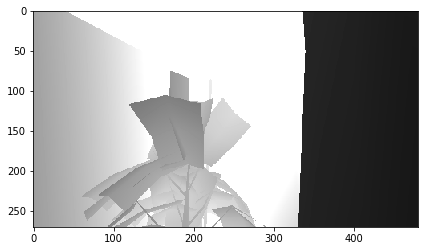

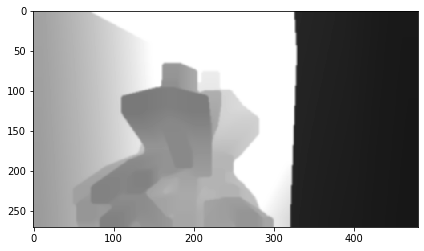

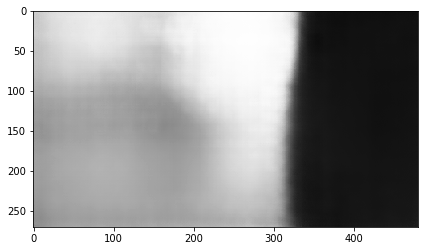

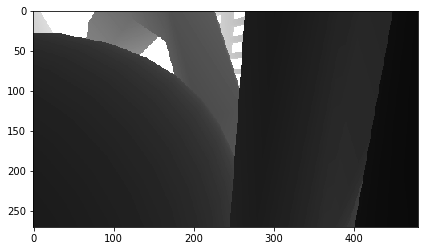

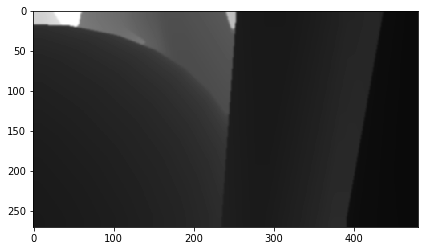

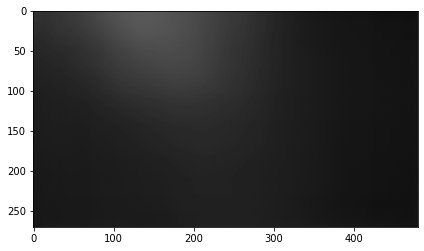

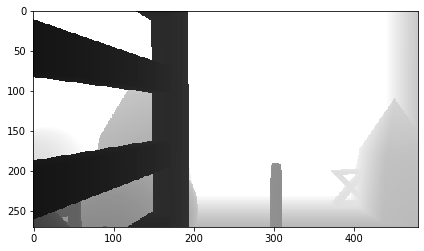

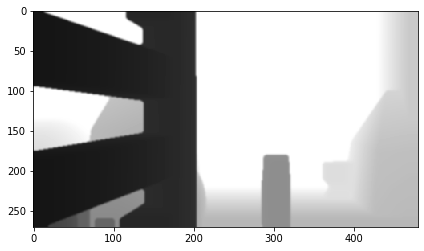

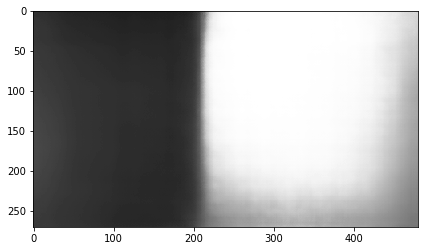

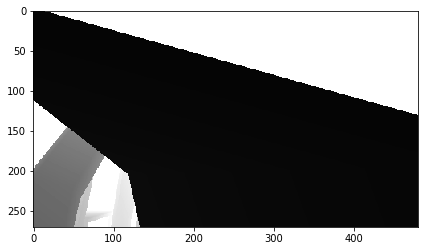

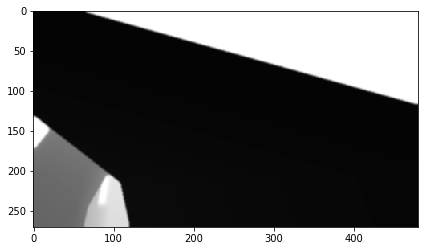

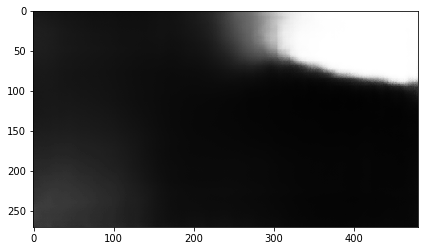

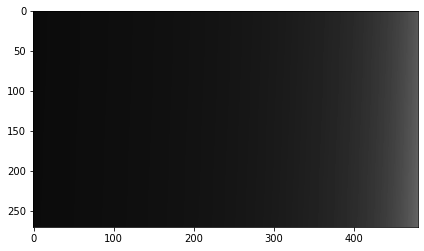

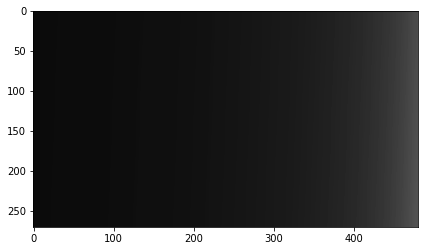

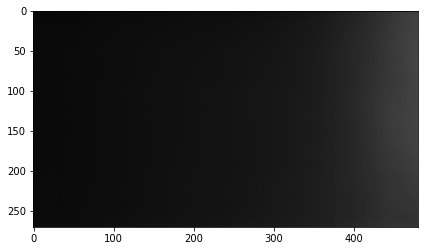

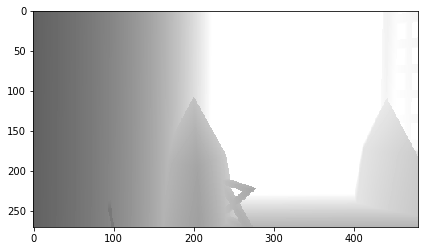

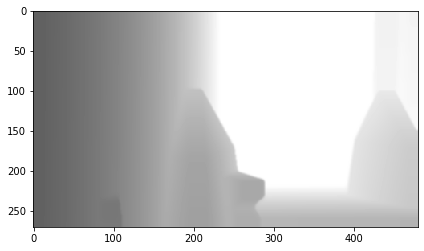

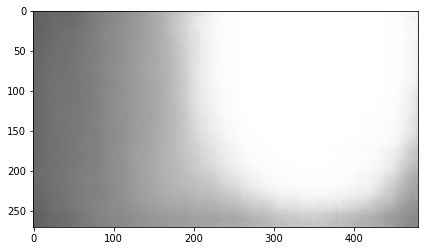

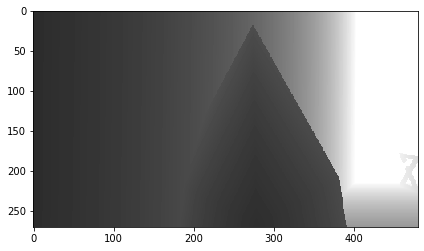

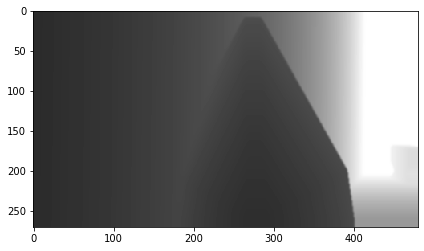

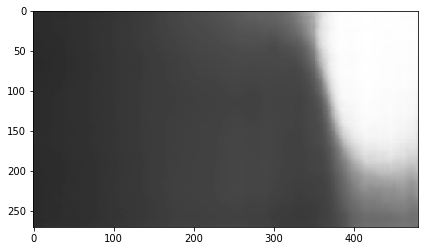

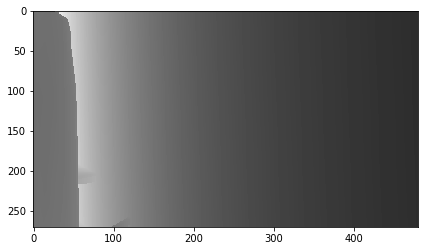

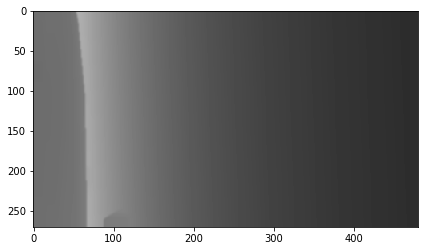

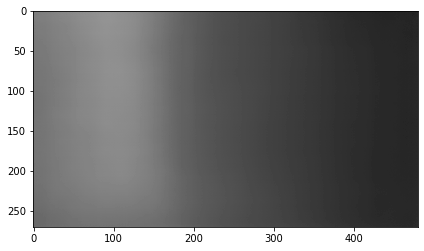

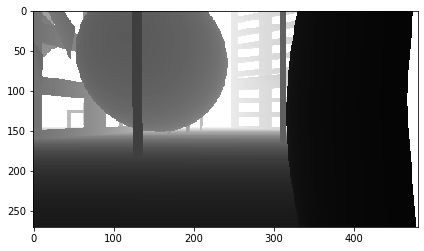

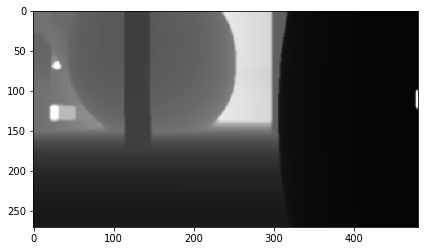

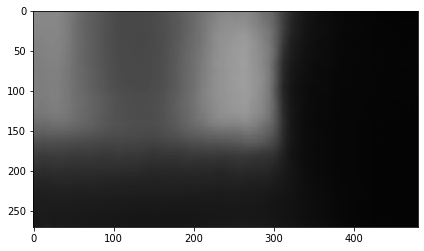

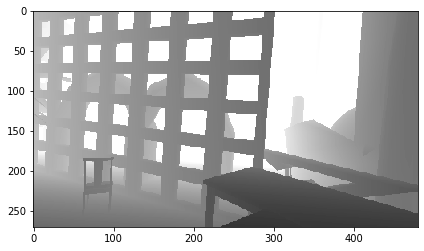

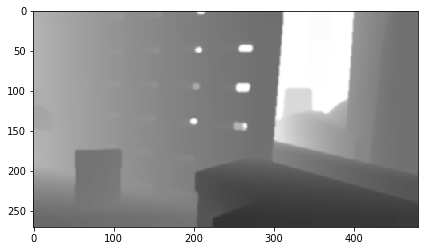

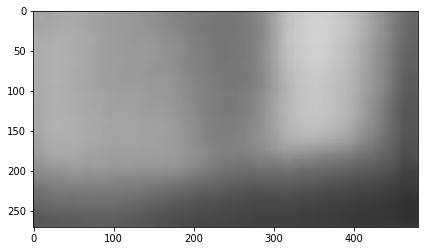

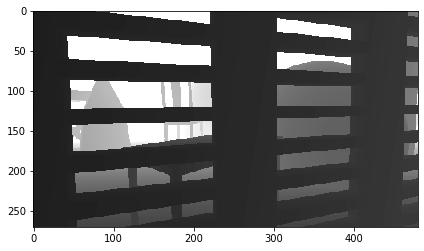

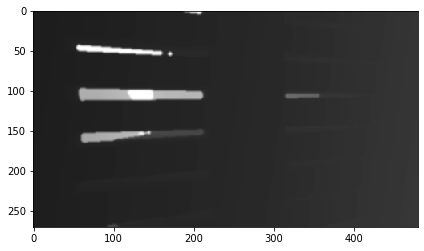

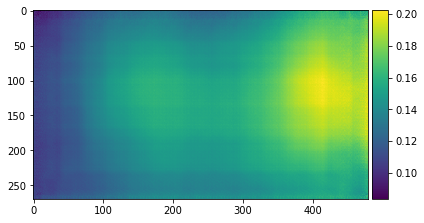

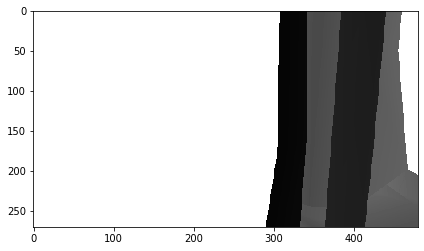

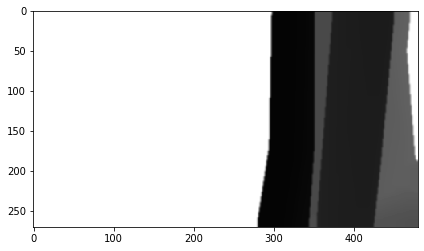

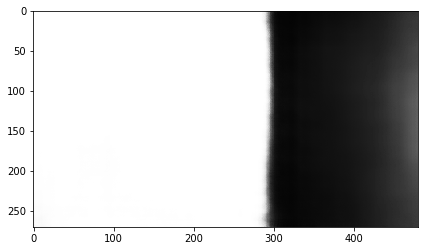

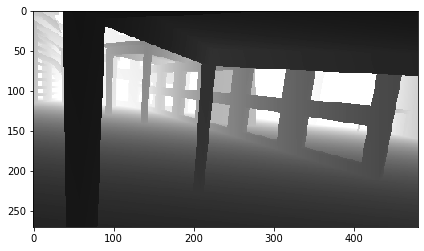

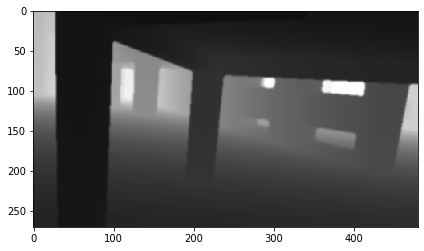

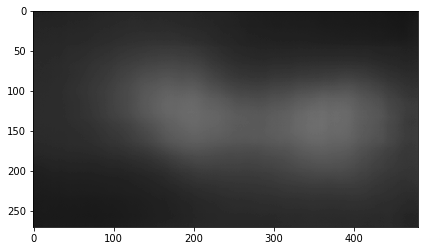

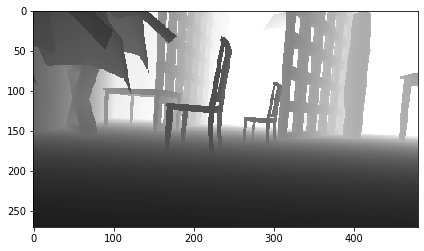

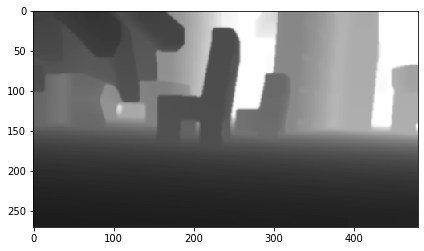

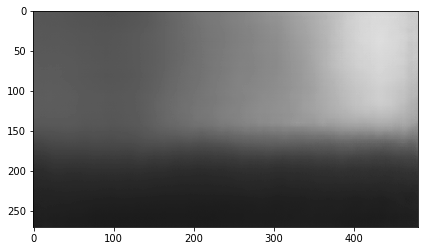

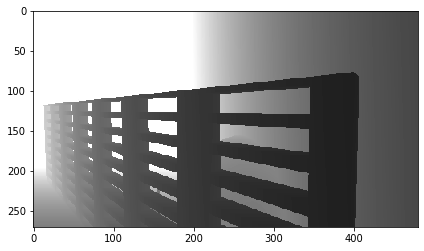

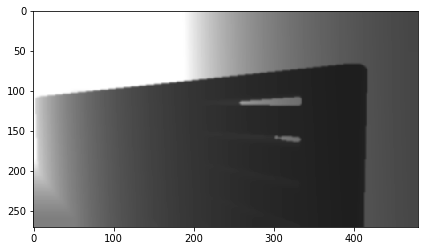

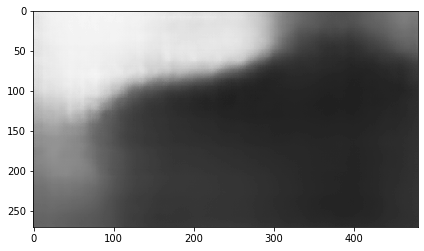

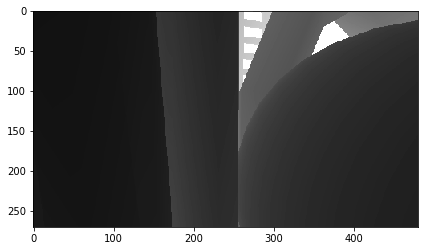

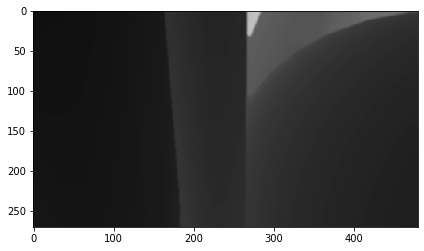

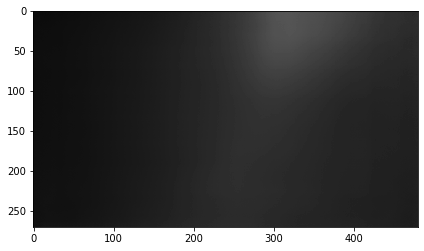

In [44]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    images, filtered_images, *_ = next(iter(test_loader))
    images, filtered_images = images.to(device0), filtered_images.to(device0)
    
    x_hats, *_ = vae_model.module.forward_test(images)

    print(images.mean(), filtered_images.mean(), x_hats.mean())
    print(images.var(), filtered_images.var(), x_hats.var())

    #gridshow([images, filtered, x_hat], n_grids=batch_size)
    for image, filtered, x_hat in zip(images, filtered_images, x_hats):
        imshow(image)
        imshow(filtered)
        imshow(x_hat)

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # load new tfrecord each time
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()

with torch.no_grad():
    images, filtered, *_ = next(iter(train_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)